In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

In [3]:
def plotCSNS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1 #actually lon
    fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
    tmask = mesh.tmask[0]
    
    lons = data.init_lat[(data.final_section != 0)]
    
    f_lons = mesh.gphif[0,:, latgridf]
    u_lons = mesh.gphiv[0,:, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

## Import data

In [4]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

lonW = 308
lonE = 327
latgridi = 300
latgridf = latgridi-1
fmask = mesh.fmask[0, :, latgridi]
tmask = mesh.tmask[0]
    
lons = data.init_lon[(data.final_section != 0)]
    
f_lons = mesh.glamf[0, latgridi]
u_lons = mesh.glamv[0, latgridi]
w_depths = mesh.gdepw_1d

m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [5]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['forpr_ros3','backadm_ros3','backvs_ros3']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2017,12,10)
enddate = dt.datetime(2021,12,27)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                print(date)
                pass


In [6]:
dict_secdata = {}

for file in files:
    
    if file not in dict_secdata:
        dict_secdata[file] = {}
    
    
    for section in sectionnum:
        
        if section not in dict_secdata[file]:
            
            dict_secdata[file][section] = {}
            
        for date in dicts[file].keys():
            
            dict_secdata[file][section] = get_secdata(dicts[file][date],section)


In [7]:
dict_secdata['forpr_ros3'][0]['final_salt']

<xarray.DataArray 'final_salt' (ntraj: 12268)>
[12268 values with dtype=float32]
Dimensions without coordinates: ntraj
Attributes:
    title:     What is final_salt ?
    longname:  Final salinity
    units:     psu

In [8]:
month_avg = np.zeros([12,len(sectransp_2018['forpr_ros3'].keys())])

for sectionnum in sectransp_2018['forpr_ros3'].keys():
    intermed = sectransp_2018['forpr_ros3'][sectionnum]
    for month in range(1,13):
        dates = [index for index, date in enumerate(datelist_vs) if date.month == month]
        selected_elements = [sectransp_2018['forpr_ros3'][sectionnum][index] for index in dates]
        month_avg[month-1,sectionnum] = np.mean(selected_elements)
    

In [9]:
dates = [index for index, date in enumerate(datelist_vs) if date.month == 1]
selected_elements = [sectransp_2018['forpr_ros3'][0][index] for index in dates]
date_jan = [datelist_vs for index in dates]

date = dt.datetime(2018,1,1)
enddate = dt.datetime(2019,1,1)

dates = []
datelist_yr = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_yr.append(date)
    date+=dt.timedelta(days=31) 

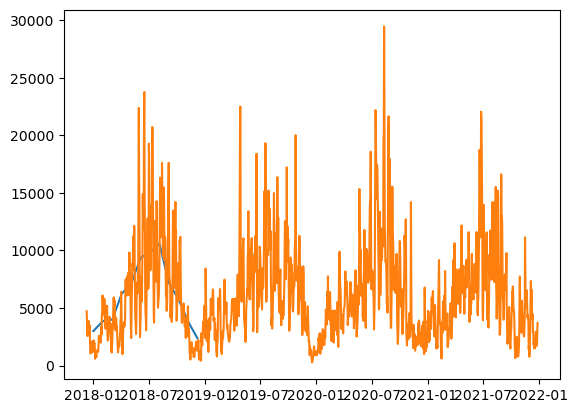

In [10]:
plt.plot(datelist_yr,month_avg[:,4])
plt.plot(datelist_vs,sectransp_2018['forpr_ros3'][4])

### Shifting functions

In [11]:
def shift_time(dfr,dfr_age,datelist,base,factor):
    shifted_time = [date + dt.timedelta(days=base+factor*dfr_age[i]/24) for i,date in enumerate(datelist)]
    dfr = pd.DataFrame({'Transport':dfr.values,'Shifted_Time': shifted_time},index=dfr.index)
    return dfr

def merge(dfr,dfr2):
    """Aligns shifted dateframes to calculate correlation

    Args:
        dfr : Forward dataframe
        dfr2 (_type_): Backward dataframe

    Returns:
        _type_: Aligned, shifted dataframes and correlation between the 2.
    """
    
    oidx = dfr.index
    ndfr = dfr.set_index('Shifted_Time')
    nidx = ndfr.index
    
    step1 = ndfr.reindex(nidx.union(oidx)) # Creates dataframe with row of each old and new index ( no overlap - 128 rows now)
    step2 = step1.sort_index() # Sorts into chronological order
    step3 = step2.interpolate(axis=0) # Interpolates in between (since dates dont line up)
    fdfr = step3
    
    #Same for 2nd dataframe
    oidx2 = dfr2.index
    ndfr2 = dfr2.set_index('Shifted_Time')
    nidx2 = ndfr2.index
    
    step1 = ndfr2.reindex(nidx2.union(oidx2))
    step2 = step1.sort_index()
    step3 = step2.interpolate(axis=0)
    fdfr2 = step3
    
    corr = fdfr.Transport.corr(fdfr2.Transport) #Correlation ignores nan values
    
    avg = 0.5*(fdfr.Transport + fdfr2.Transport)
    return fdfr,fdfr2,corr,avg

### Import density data

In [12]:
# Importing density and tidal data

density_ros = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2017-22_rosarioNS.csv')
dens_diff_ros = np.array(density_ros.south - density_ros.north)

# density_rosVS = pd.read_csv('sigma_2018_rosariopr_202111_meanv2.csv')
# dens_diff_rosVS = np.array(density_rosVS.south - density_rosVS.north)

# density_haro = pd.read_csv('sigma_2018_harovs_202111_mean_v2.csv')
# dens_diff_haro = np.array(density_haro.south - density_haro.north)

tides = pd.read_csv('../notebooks/low_pass_tide_2018-22_BP.csv')
tides_ros = pd.read_csv('low_pass_tide_18-22.csv')

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_tides = []

while date <= enddate:
    datelist_tides.append(date)
    date+=dt.timedelta(days=1)

#Confirm dates are same length

print(len(datelist_tides))
print(tides.iloc[:,1].shape)   
 
date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)
    
dens_diff_ros

2191
(2191,)


array([24.29067796, 24.300836  , 24.17309402, ..., 24.34024707,
       24.07221684, 24.04299616])

In [13]:
wind = pd.read_csv('../notebooks/day_avg_wind_17-22.csv')
x = wind['time']
y = wind['wind']

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_winds = []

while date <= enddate:
    datelist_winds.append(date)
    date+=dt.timedelta(days=1)
    
y_mean4 = y.rolling(window=4, center=True).mean()

#### Rosario to adm

In [14]:
PRtoadm_rosl = sectransp_2018['forpr_ros3'][2]
PRtoadm_rosbl = sectransp_2018['backadm_ros3'][4]

PRtoadm_ros = pd.Series(PRtoadm_rosl,index=datelist_vs)
PRtoadm_rosb = pd.Series(PRtoadm_rosbl,index=datelist_vs)

In [15]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm_ros,age_2018['forpr_ros3'][2],datelist_vs,base,factor)
        dfr2 = shift_time(PRtoadm_rosb,age_2018['backadm_ros3'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.595:
            print (base, factor, corr_arr[i, j])

In [16]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-0.75] [0.2]


0.592742230095195


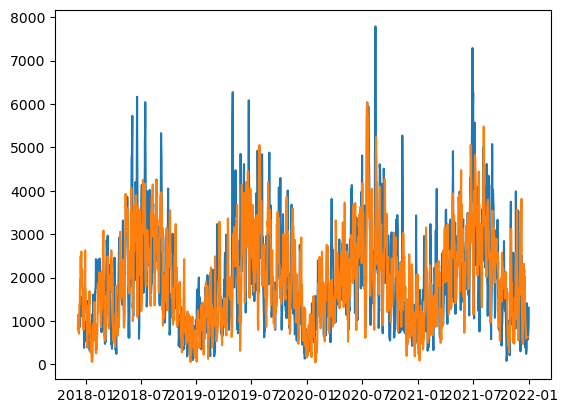

In [17]:
PRtoadm_ros_sh = shift_time(PRtoadm_ros,age_2018['forpr_ros3'][2],datelist_vs,base_adm[0],factor_adm[0])
PRtoadm_rosb_sh = shift_time(PRtoadm_rosb,age_2018['backadm_ros3'][4],datelist_vs,-base_adm[0],-factor_adm[0])

PRtoadm_ros_m,PRtoadm_rosb_m,c,PRtoadm_ros_avg = merge(PRtoadm_ros_sh,PRtoadm_rosb_sh)
print(c)

plt.plot(PRtoadm_ros_m.Transport)
plt.plot(PRtoadm_rosb_m.Transport)

#### Now do this same for only 2018

In [18]:
PRtoadm2018_rosl = sectransp_2018['forpr_ros3'][2][0:385]
PRtoadm2018_rosbl = sectransp_2018['backadm_ros3'][4][0:385]

PRtoadm2018_ros = pd.Series(PRtoadm2018_rosl,index=datelist_vs[0:385])
PRtoadm2018_rosb = pd.Series(PRtoadm2018_rosbl,index=datelist_vs[0:385])

In [19]:
PRtoadm2018_rosb

2017-12-10     820.595292
2017-12-11    1149.001901
2017-12-12     749.904988
2017-12-13     707.988881
2017-12-14     889.198318
                 ...     
2018-12-25     511.828848
2018-12-26     455.538490
2018-12-27     789.910587
2018-12-28     606.814459
2018-12-29     413.102430
Length: 385, dtype: float64

In [20]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm2018_ros,age_2018['forpr_ros3'][2][0:385],datelist_vs[0:385],base,factor)
        dfr2 = shift_time(PRtoadm2018_rosb,age_2018['backadm_ros3'][4][0:385],datelist_vs[0:385],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.65:
            print (base, factor, corr_arr[i, j])

-0.8499999999999999 0.15000000000000102 0.6520339623467446
-0.7999999999999998 0.15000000000000102 0.6550074656313384
-0.7499999999999998 0.15000000000000102 0.6539740414298298


In [21]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-0.8] [0.15]


0.6550074656313384


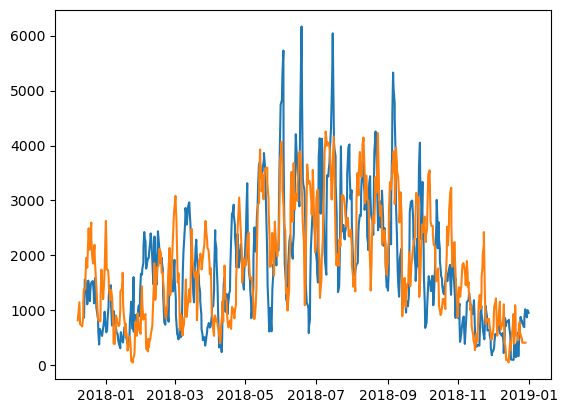

In [22]:
PRtoadm2018_ros_sh = shift_time(PRtoadm2018_ros,age_2018['forpr_ros3'][2][0:385],datelist_vs[0:385],base_adm[0],factor_adm[0])
PRtoadm2018_rosb_sh = shift_time(PRtoadm2018_rosb,age_2018['backadm_ros3'][4][0:385],datelist_vs[0:385],-base_adm[0],-factor_adm[0])

PRtoadm2018_ros_m,PRtoadm2018_rosb_m,c,PRtoadm2018_ros_avg = merge(PRtoadm2018_ros_sh,PRtoadm2018_rosb_sh)
print(c)

plt.plot(PRtoadm2018_ros_m.Transport)
plt.plot(PRtoadm2018_rosb_m.Transport)

#### Now do this for only 2019

In [23]:
PRtoadm2019_rosl = sectransp_2018['forpr_ros3'][2][387:750]
PRtoadm2019_rosbl = sectransp_2018['backadm_ros3'][4][387:750]

PRtoadm2019_ros = pd.Series(PRtoadm2019_rosl,index=datelist_vs[387:750])
PRtoadm2019_rosb = pd.Series(PRtoadm2019_rosbl,index=datelist_vs[387:750])

In [24]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm2019_ros,age_2018['forpr_ros3'][2][387:750],datelist_vs[387:750],base,factor)
        dfr2 = shift_time(PRtoadm2019_rosb,age_2018['backadm_ros3'][4][387:750],datelist_vs[387:750],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])

-1.0 0.3500000000000012 0.5777469311041056
-0.95 0.3500000000000012 0.5791571184417817
-0.95 0.40000000000000124 0.5729188902053723
-0.8999999999999999 0.3500000000000012 0.5793937019868262
-0.8499999999999999 0.3500000000000012 0.5733710202894302
-0.7999999999999998 0.3500000000000012 0.5702911291823065
-0.7499999999999998 0.3500000000000012 0.5769931003043859
-0.6999999999999997 0.3500000000000012 0.5721971300523871
-0.6499999999999997 0.3500000000000012 0.5783799269399205
-0.5999999999999996 0.3500000000000012 0.5722042422731665
-0.49999999999999956 0.3500000000000012 0.5761165835921018
-0.4499999999999995 0.3500000000000012 0.580890528411347
-0.39999999999999947 0.3500000000000012 0.5752051423728666
-0.3499999999999994 0.3500000000000012 0.579568871086162
-0.2999999999999994 0.3500000000000012 0.5804388726752633
-0.24999999999999933 0.3500000000000012 0.577656950259087
-0.1999999999999993 0.30000000000000115 0.5703759282372034
-0.1999999999999993 0.3500000000000012 0.57496938262127

In [25]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[0.55] [0.3]


0.5871562004110922


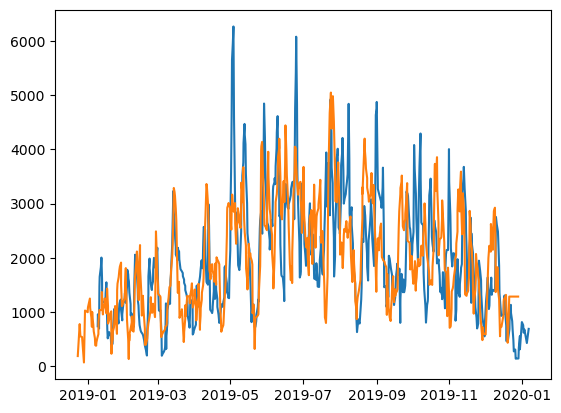

In [26]:
PRtoadm2019_ros_sh = shift_time(PRtoadm2019_ros,age_2018['forpr_ros3'][2][387:750],datelist_vs[387:750],base_adm[0],factor_adm[0])
PRtoadm2019_rosb_sh = shift_time(PRtoadm2019_rosb,age_2018['backadm_ros3'][4][387:750],datelist_vs[387:750],-base_adm[0],-factor_adm[0])

PRtoadm2019_ros_m,PRtoadm2019_rosb_m,c,PRtoadm2019_ros_avg = merge(PRtoadm2019_ros_sh,PRtoadm2019_rosb_sh)
print(c)

plt.plot(PRtoadm2019_ros_m.Transport)
plt.plot(PRtoadm2019_rosb_m.Transport)

#### Now for 2020

In [82]:
PRtoadm2020_rosl = sectransp_2018['forpr_ros3'][2][750:1100]
PRtoadm2020_rosbl = sectransp_2018['backadm_ros3'][4][750:1100]

PRtoadm2020_ros = pd.Series(PRtoadm2020_rosl,index=datelist_vs[750:1100])
PRtoadm2020_rosb = pd.Series(PRtoadm2020_rosbl,index=datelist_vs[750:1100])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm2020_ros,age_2018['forpr_ros3'][2][750:1100],datelist_vs[750:1100],base,factor)
        dfr2 = shift_time(PRtoadm2020_rosb,age_2018['backadm_ros3'][4][750:1100],datelist_vs[750:1100],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

-1.0 0.20000000000000107 0.6104295130575822
-1.0 0.2500000000000011 0.6509615919525132
-1.0 0.30000000000000115 0.6417166690258237
-1.0 0.3500000000000012 0.5906704817937787
-0.95 0.20000000000000107 0.6165403110187077
-0.95 0.2500000000000011 0.6389266492729504
-0.95 0.30000000000000115 0.6378418190714455
-0.95 0.3500000000000012 0.5887965279459566
-0.8999999999999999 0.20000000000000107 0.6205226700840085
-0.8999999999999999 0.2500000000000011 0.6402613089619839
-0.8999999999999999 0.30000000000000115 0.6318072061666605
-0.8999999999999999 0.3500000000000012 0.5936435976924304
-0.8499999999999999 0.20000000000000107 0.6162716858215468
-0.8499999999999999 0.2500000000000011 0.6334164839997868
-0.8499999999999999 0.30000000000000115 0.6277628844564903
-0.8499999999999999 0.3500000000000012 0.5925862100890901
-0.7999999999999998 0.20000000000000107 0.6280086126026809
-0.7999999999999998 0.2500000000000011 0.6374279693271604
-0.7999999999999998 0.30000000000000115 0.6303006900463674
-0.7

0.673417943584732


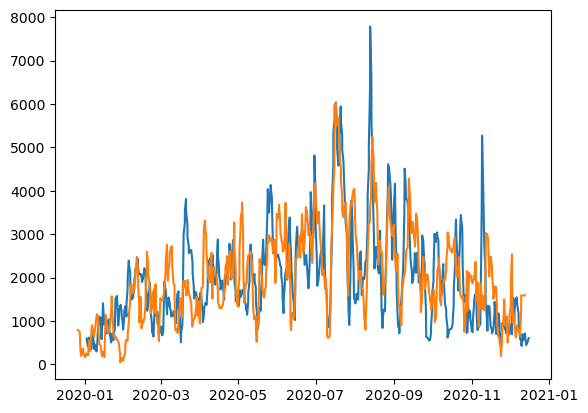

In [84]:
PRtoadm2020_ros_sh = shift_time(PRtoadm2020_ros,age_2018['forpr_ros3'][2][750:1100],datelist_vs[750:1100],base_adm[0],factor_adm[0])
PRtoadm2020_rosb_sh = shift_time(PRtoadm2020_rosb,age_2018['backadm_ros3'][4][750:1100],datelist_vs[750:1100],-base_adm[0],-factor_adm[0])

PRtoadm2020_ros_m,PRtoadm2020_rosb_m,c,PRtoadm2020_ros_avg = merge(PRtoadm2020_ros_sh,PRtoadm2020_rosb_sh)
print(c)

plt.plot(PRtoadm2020_ros_m.Transport)
plt.plot(PRtoadm2020_rosb_m.Transport)

#### Now for 2021

In [85]:
PRtoadm2021_rosl = sectransp_2018['forpr_ros3'][2][1100:]
PRtoadm2021_rosbl = sectransp_2018['backadm_ros3'][4][1100:]

PRtoadm2021_ros = pd.Series(PRtoadm2021_rosl,index=datelist_vs[1100:])
PRtoadm2021_rosb = pd.Series(PRtoadm2021_rosbl,index=datelist_vs[1100:])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm2021_ros,age_2018['forpr_ros3'][2][1100:],datelist_vs[1100:],base,factor)
        dfr2 = shift_time(PRtoadm2021_rosb,age_2018['backadm_ros3'][4][1100:],datelist_vs[1100:],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

-0.95 0.20000000000000107 0.5756617647768054
-0.8999999999999999 0.15000000000000102 0.573092907537767
-0.8999999999999999 0.20000000000000107 0.5782642814423462
-0.8499999999999999 0.15000000000000102 0.5778458216518926
-0.8499999999999999 0.20000000000000107 0.586955446084388
-0.7999999999999998 0.15000000000000102 0.573844437866961
-0.7999999999999998 0.20000000000000107 0.5883281888008715
-0.7499999999999998 0.15000000000000102 0.5715591740646674
-0.7499999999999998 0.20000000000000107 0.5766182523590868
-0.6999999999999997 0.20000000000000107 0.5734388725047763
-0.6499999999999997 0.15000000000000102 0.5737293238848831
-0.6499999999999997 0.20000000000000107 0.572756251745471
-0.5999999999999996 0.15000000000000102 0.5727515508068362
-0.3499999999999994 0.15000000000000102 0.5727751979439986
-0.2999999999999994 0.15000000000000102 0.5780502166705959
-0.24999999999999933 0.15000000000000102 0.5810242328514293
-0.1999999999999993 0.15000000000000102 0.5924898361546177
-0.14999999999

0.5957121234250642


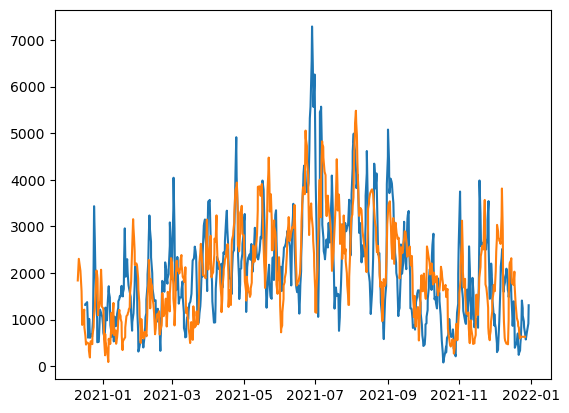

In [86]:
PRtoadm2021_ros_sh = shift_time(PRtoadm2021_ros,age_2018['forpr_ros3'][2][1100:],datelist_vs[1100:],base_adm[0],factor_adm[0])
PRtoadm2021_rosb_sh = shift_time(PRtoadm2021_rosb,age_2018['backadm_ros3'][4][1100:],datelist_vs[1100:],-base_adm[0],-factor_adm[0])

PRtoadm2021_ros_m,PRtoadm2021_rosb_m,c,PRtoadm2021_ros_avg = merge(PRtoadm2021_ros_sh,PRtoadm2021_rosb_sh)
print(c)

plt.plot(PRtoadm2021_ros_m.Transport)
plt.plot(PRtoadm2021_rosb_m.Transport)

### PR to VicSill

In [27]:
PRtovs_rosl = sectransp_2018['forpr_ros3'][4]
PRtovs_rosbl = sectransp_2018['backvs_ros3'][4]

PRtovs_ros = pd.Series(PRtovs_rosl,index=datelist_vs)
PRtovs_rosb = pd.Series(PRtovs_rosbl,index=datelist_vs)

In [28]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs_ros,age_2018['forpr_ros3'][4],datelist_vs,base,factor)
        dfr2 = shift_time(PRtovs_rosb,age_2018['backvs_ros3'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.68:
            print (base, factor, corr_arr[i, j])

-1.0 0.2500000000000011 0.7192560291908261
-1.0 0.30000000000000115 0.7245356145028561
-0.95 0.2500000000000011 0.7209750375621947
-0.95 0.30000000000000115 0.7147728783587318
-0.8999999999999999 0.2500000000000011 0.7221319522202964
-0.8999999999999999 0.30000000000000115 0.7105918934670734
-0.8499999999999999 0.2500000000000011 0.7210199659338652
-0.8499999999999999 0.30000000000000115 0.7094018014298026
-0.7999999999999998 0.2500000000000011 0.7252450197569953
-0.7999999999999998 0.30000000000000115 0.7077046909152404
-0.7499999999999998 0.2500000000000011 0.7287390489385727
-0.7499999999999998 0.30000000000000115 0.7024255913992447
-0.6999999999999997 0.20000000000000107 0.6817365380137779
-0.6999999999999997 0.2500000000000011 0.7276186838951305
-0.6999999999999997 0.30000000000000115 0.6958740313272883
-0.6499999999999997 0.20000000000000107 0.6828546517773965
-0.6499999999999997 0.2500000000000011 0.7294322140320536
-0.6499999999999997 0.30000000000000115 0.6932788167835134
-0.5

In [29]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-0.65] [0.25]


0.7294322140320536


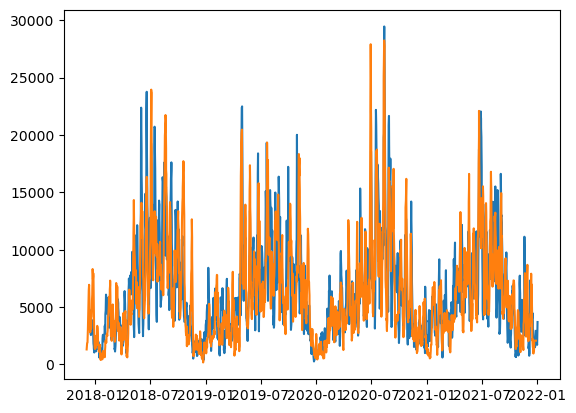

In [30]:
PRtovs_ros_sh = shift_time(PRtovs_ros,age_2018['forpr_ros3'][4],datelist_vs,base_adm[0],factor_adm[0])
PRtovs_rosb_sh = shift_time(PRtovs_rosb,age_2018['backvs_ros3'][4],datelist_vs,-base_adm[0],-factor_adm[0])

PRtovs_ros_m,PRtovs_rosb_m,c,PRtovs_ros_avg = merge(PRtovs_ros_sh,PRtovs_rosb_sh)
print(c)

plt.plot(PRtovs_ros_m.Transport)
plt.plot(PRtovs_rosb_m.Transport)

#### Now do this for only 2018

In [31]:
PRtovs2018_rosl = sectransp_2018['forpr_ros3'][4][0:385]
PRtovs2018_rosbl = sectransp_2018['backvs_ros3'][4][0:385]

PRtovs2018_ros = pd.Series(PRtovs2018_rosl,index=datelist_vs[0:385])
PRtovs2018_rosb = pd.Series(PRtovs2018_rosbl,index=datelist_vs[0:385])

In [32]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2018_ros,age_2018['forpr_ros3'][4][0:385],datelist_vs[0:385],base,factor)
        dfr2 = shift_time(PRtovs2018_rosb,age_2018['backvs_ros3'][4][0:385],datelist_vs[0:385],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.73:
            print (base, factor, corr_arr[i, j])

-1.0 0.30000000000000115 0.7383132790320881
-0.7499999999999998 0.2500000000000011 0.7303184671278201
-0.6499999999999997 0.2500000000000011 0.7314656453815972
-0.5999999999999996 0.2500000000000011 0.7307758320789479
-0.39999999999999947 0.2500000000000011 0.730445030017987
-0.3499999999999994 0.2500000000000011 0.7342245171321492
0.15000000000000102 0.20000000000000107 0.7317687809152374
0.20000000000000107 0.20000000000000107 0.7339911066854953


In [33]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-1.] [0.3]


0.7383132790320881


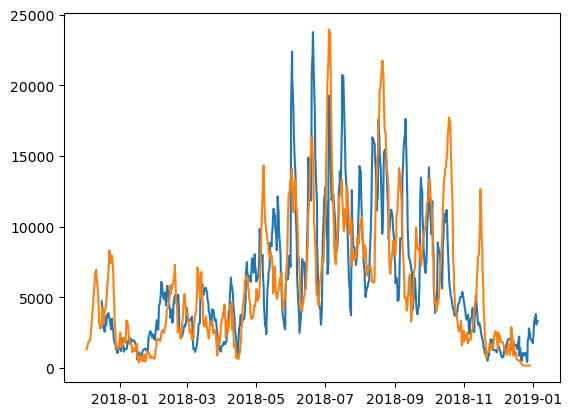

In [34]:
PRtovs2018_ros_sh = shift_time(PRtovs2018_ros,age_2018['forpr_ros3'][4][0:385],datelist_vs[0:385],base_adm[0],factor_adm[0])
PRtovs2018_rosb_sh = shift_time(PRtovs2018_rosb,age_2018['backvs_ros3'][4][0:385],datelist_vs[0:385],-base_adm[0],-factor_adm[0])

PRtovs2018_ros_m,PRtovs2018_rosb_m,c,PRtovs2018_ros_avg = merge(PRtovs2018_ros_sh,PRtovs2018_rosb_sh)
print(c)

plt.plot(PRtovs2018_ros_m.Transport)
plt.plot(PRtovs2018_rosb_m.Transport)

#### Now do this for 2019

In [35]:
PRtovs2019_rosl = sectransp_2018['forpr_ros3'][4][387:750]
PRtovs2019_rosbl = sectransp_2018['backvs_ros3'][4][387:750]

PRtovs2019_ros = pd.Series(PRtovs2019_rosl,index=datelist_vs[387:750])
PRtovs2019_rosb = pd.Series(PRtovs2019_rosbl,index=datelist_vs[387:750])

In [36]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2019_ros,age_2018['forpr_ros3'][4][387:750],datelist_vs[387:750],base,factor)
        dfr2 = shift_time(PRtovs2019_rosb,age_2018['backvs_ros3'][4][387:750],datelist_vs[387:750],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])

-1.0 0.2500000000000011 0.5741320056090071
-1.0 0.30000000000000115 0.6220438277197878
-0.95 0.2500000000000011 0.5827176235682396
-0.95 0.30000000000000115 0.6082612801904554
-0.8999999999999999 0.2500000000000011 0.5845384822839848
-0.8999999999999999 0.30000000000000115 0.6028273773821411
-0.8499999999999999 0.2500000000000011 0.5869584948458441
-0.8499999999999999 0.30000000000000115 0.6040121745042676
-0.7999999999999998 0.2500000000000011 0.5987542648017149
-0.7999999999999998 0.30000000000000115 0.6012805567429336
-0.7499999999999998 0.2500000000000011 0.6028668076937831
-0.7499999999999998 0.30000000000000115 0.5919717196243421
-0.6999999999999997 0.2500000000000011 0.6047558945987782
-0.6999999999999997 0.30000000000000115 0.5903901622986437
-0.6499999999999997 0.2500000000000011 0.6059945244328745
-0.6499999999999997 0.30000000000000115 0.5936742432742147
-0.5999999999999996 0.2500000000000011 0.6067024677037247
-0.5999999999999996 0.30000000000000115 0.5965747621522831
-0.54

In [37]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-1.] [0.3]


0.6220438277197878


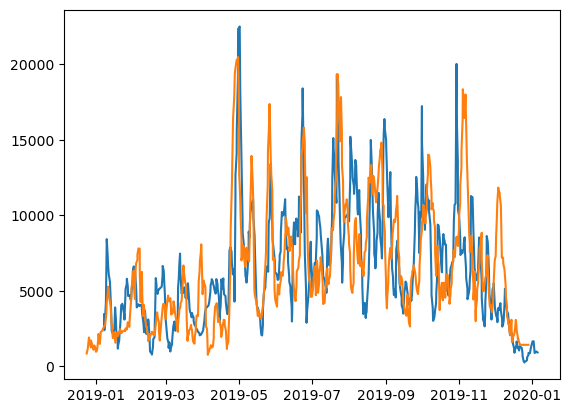

In [38]:
PRtovs2019_ros_sh = shift_time(PRtovs2019_ros,age_2018['forpr_ros3'][4][387:750],datelist_vs[387:750],base_adm[0],factor_adm[0])
PRtovs2019_rosb_sh = shift_time(PRtovs2019_rosb,age_2018['backvs_ros3'][4][387:750],datelist_vs[387:750],-base_adm[0],-factor_adm[0])

PRtovs2019_ros_m,PRtovs2019_rosb_m,c,PRtovs2019_ros_avg = merge(PRtovs2019_ros_sh,PRtovs2019_rosb_sh)
print(c)

plt.plot(PRtovs2019_ros_m.Transport)
plt.plot(PRtovs2019_rosb_m.Transport)

#### Now this for 2020

In [76]:
PRtovs2020_rosl = sectransp_2018['forpr_ros3'][4][750:1100]
PRtovs2020_rosbl = sectransp_2018['backvs_ros3'][4][750:1100]

PRtovs2020_ros = pd.Series(PRtovs2020_rosl,index=datelist_vs[750:1100])
PRtovs2020_rosb = pd.Series(PRtovs2020_rosbl,index=datelist_vs[750:1100])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2020_ros,age_2018['forpr_ros3'][4][750:1100],datelist_vs[750:1100],base,factor)
        dfr2 = shift_time(PRtovs2020_rosb,age_2018['backvs_ros3'][4][750:1100],datelist_vs[750:1100],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

-1.0 0.15000000000000102 0.571321978137322
-1.0 0.20000000000000107 0.7175488491378653
-1.0 0.2500000000000011 0.8137006580613872
-1.0 0.30000000000000115 0.7846623811154952
-1.0 0.3500000000000012 0.6611529449651466
-0.95 0.20000000000000107 0.7317154931152768
-0.95 0.2500000000000011 0.8142473689022778
-0.95 0.30000000000000115 0.780089714287132
-0.95 0.3500000000000012 0.6625920358455177
-0.8999999999999999 0.15000000000000102 0.5705208697079831
-0.8999999999999999 0.20000000000000107 0.7394592271513852
-0.8999999999999999 0.2500000000000011 0.8161069176401426
-0.8999999999999999 0.30000000000000115 0.7752188754890192
-0.8999999999999999 0.3500000000000012 0.6571247900658342
-0.8499999999999999 0.15000000000000102 0.5861965093309275
-0.8499999999999999 0.20000000000000107 0.7466733374766784
-0.8499999999999999 0.2500000000000011 0.8151334714775476
-0.8499999999999999 0.30000000000000115 0.7702260971784977
-0.8499999999999999 0.3500000000000012 0.6493285431326905
-0.7999999999999998 

0.8197286436558551


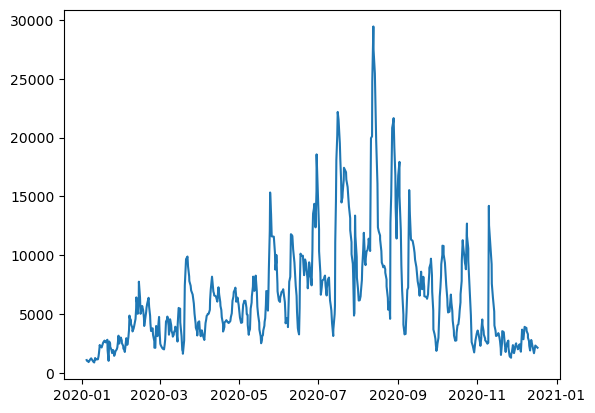

In [77]:
PRtovs2020_ros_sh = shift_time(PRtovs2020_ros,age_2018['forpr_ros3'][4][750:1100],datelist_vs[750:1100],base_adm[0],factor_adm[0])
PRtovs2020_rosb_sh = shift_time(PRtovs2020_rosb,age_2018['backvs_ros3'][4][750:1100],datelist_vs[750:1100],-base_adm[0],-factor_adm[0])

PRtovs2020_ros_m,PRtovs2020_rosb_m,c,PRtovs2020_ros_avg = merge(PRtovs2020_ros_sh,PRtovs2020_rosb_sh)
print(c)

plt.plot(PRtovs2020_ros_m.Transport)

#### Now for 2021

In [78]:
PRtovs2021_rosl = sectransp_2018['forpr_ros3'][4][1100:]
PRtovs2021_rosbl = sectransp_2018['backvs_ros3'][4][1100:]

PRtovs2021_ros = pd.Series(PRtovs2021_rosl,index=datelist_vs[1100:])
PRtovs2021_rosb = pd.Series(PRtovs2021_rosbl,index=datelist_vs[1100:])

# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs2021_ros,age_2018['forpr_ros3'][4][1100:],datelist_vs[1100:],base,factor)
        dfr2 = shift_time(PRtovs2021_rosb,age_2018['backvs_ros3'][4][1100:],datelist_vs[1100:],-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.57:
            print (base, factor, corr_arr[i, j])
            
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

-1.0 0.15000000000000102 0.5704891275671328
-1.0 0.20000000000000107 0.654712740711557
-1.0 0.2500000000000011 0.6948610730627534
-1.0 0.30000000000000115 0.6898578988160428
-1.0 0.3500000000000012 0.6273566591936713
-0.95 0.15000000000000102 0.5765779570385905
-0.95 0.20000000000000107 0.6517174643224701
-0.95 0.2500000000000011 0.6975784441303572
-0.95 0.30000000000000115 0.6848629946080182
-0.95 0.3500000000000012 0.6312110635852768
-0.8999999999999999 0.15000000000000102 0.592688297604789
-0.8999999999999999 0.20000000000000107 0.6493403220733198
-0.8999999999999999 0.2500000000000011 0.7003834409764249
-0.8999999999999999 0.30000000000000115 0.677216973620679
-0.8999999999999999 0.3500000000000012 0.6401652934106871
-0.8499999999999999 0.15000000000000102 0.6030092610310188
-0.8499999999999999 0.20000000000000107 0.6617468402425859
-0.8499999999999999 0.2500000000000011 0.6913499669971632
-0.8499999999999999 0.30000000000000115 0.6799890896663587
-0.8499999999999999 0.350000000000

0.7051958393081365


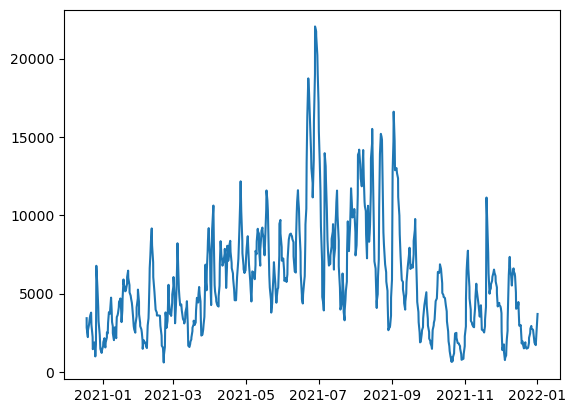

In [81]:
PRtovs2021_ros_sh = shift_time(PRtovs2021_ros,age_2018['forpr_ros3'][4][1100:],datelist_vs[1100:],base_adm[0],factor_adm[0])
PRtovs2021_rosb_sh = shift_time(PRtovs2021_rosb,age_2018['backvs_ros3'][4][1100:],datelist_vs[1100:],-base_adm[0],-factor_adm[0])

PRtovs2021_ros_m,PRtovs2021_rosb_m,c,PRtovs2021_ros_avg = merge(PRtovs2021_ros_sh,PRtovs2021_rosb_sh)
print(c)

plt.plot(PRtovs2021_ros_m.Transport)

#### Flow south through Rosario

In [39]:
rostosouth_2018 = PRtovs2018_ros_avg + PRtoadm2018_ros_avg

date2018_rossh = list(rostosouth_2018.dropna().index)

mask = np.isin(datelist_dens,date2018_rossh)
densdiff_ros2018 = dens_diff_ros[mask]
# densdiff_ros2 = dens_diff_rosVS[mask]
date_dens_2018sh = np.array(datelist_dens)[mask]

corr_rostosouth2018,p = stats.spearmanr(densdiff_ros2018,rostosouth_2018.dropna())
print('2018:',corr_rostosouth2018)

# mask = np.isin(datelist_tides,date2018_rossh)
# tides2018_sh = tides.vozocrtx[mask]

rostosouth_2019 = PRtovs2019_ros_avg.dropna() + PRtoadm2019_ros_avg.dropna()

date2019_rossh = list(rostosouth_2019.dropna().index)

mask = np.isin(datelist_dens,date2019_rossh)
densdiff_ros2019 = dens_diff_ros[mask]
# densdiff_ros2 = dens_diff_rosVS[mask]
date_dens_2019sh = np.array(datelist_dens)[mask]

corr_rostosouth2019,p = stats.spearmanr(densdiff_ros2019,rostosouth_2019.dropna())
print('2019:',corr_rostosouth2019)


2018: 0.8292558573214036
2019: 0.7061271358887469


In [40]:
rostosouth_2018.dropna()

2017-12-16    5717.056867
2017-12-17    5410.744930
2017-12-18    4982.965563
2017-12-19    5634.886245
2017-12-20    5908.381155
                 ...     
2018-12-25    1305.061622
2018-12-26    1100.395288
2018-12-27    1563.614370
2018-12-28    1874.142372
2018-12-29    1986.504325
Name: Transport, Length: 379, dtype: float64

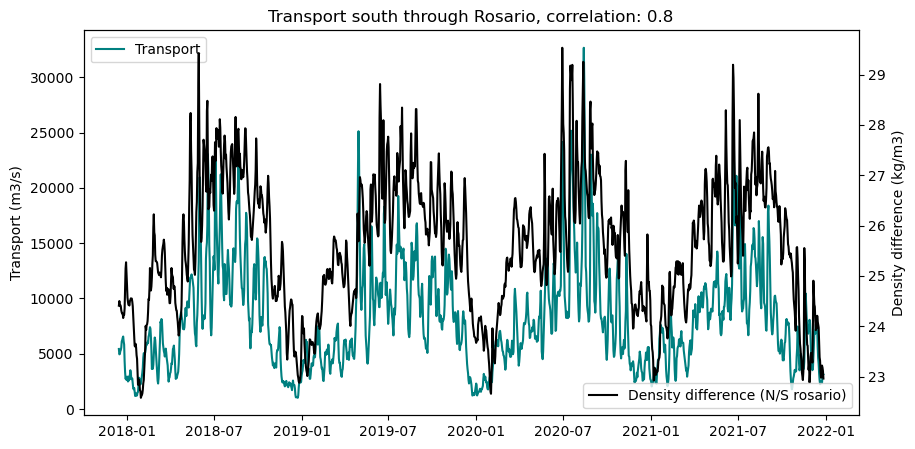

In [41]:
rostosouth = PRtovs_ros_avg + PRtoadm_ros_avg
date_rossh = list(rostosouth.dropna().index)

mask = np.isin(datelist_dens,date_rossh)
densdiff_ros = dens_diff_ros[mask]
# densdiff_ros2 = dens_diff_rosVS[mask]
date_dens_sh = np.array(datelist_dens)[mask]

corr_rostosouth,p = stats.spearmanr(densdiff_ros,rostosouth.dropna())

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(rostosouth.dropna(),color='teal',label='Transport')
ax2=ax.twinx()
ax2.plot(date_dens_sh,densdiff_ros,color='k',label='Density difference (N/S rosario)')
ax.set_title(f'Transport south through Rosario, correlation: {np.round(corr_rostosouth,2)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
ax.legend(loc=2)
ax2.legend()

Text(0.5, 1.0, 'corr = -0.085')

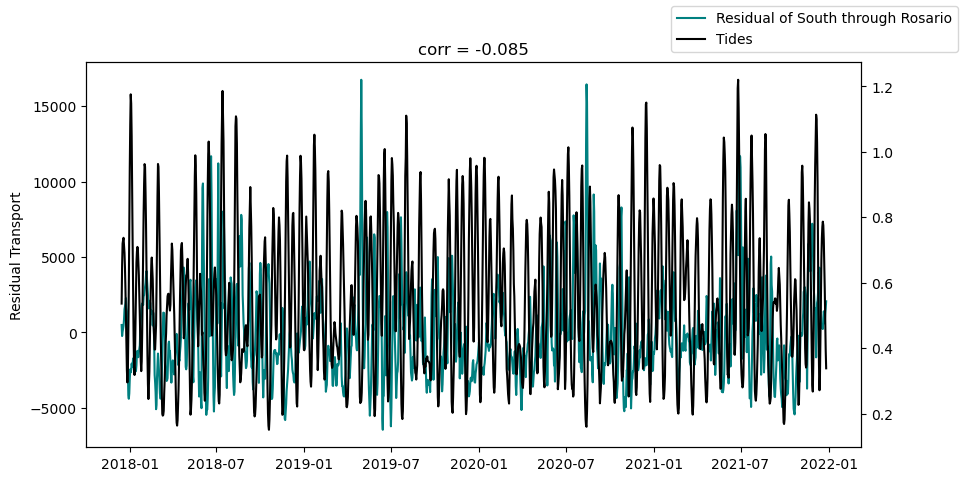

In [42]:
slope,intercept = np.polyfit(densdiff_ros,rostosouth.dropna(),1)
ddline = slope*densdiff_ros+intercept
res = rostosouth.dropna() - ddline

# slope,intercept = np.polyfit(densdiff_ros2,rostosouth.dropna(),1)
# ddline2 = slope*densdiff_ros2+intercept
# res_ros2 = rostosouth.dropna() - ddline2

mask = np.isin(datelist_tides,date_rossh)
date_tides_sh = np.array(datelist_tides)[mask]
tides_sh = tides.vozocrtx[mask]

corr,p = stats.spearmanr(tides_sh,res)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='k',label='Tides')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')

Text(0.5, 1.0, 'corr = -0.219')

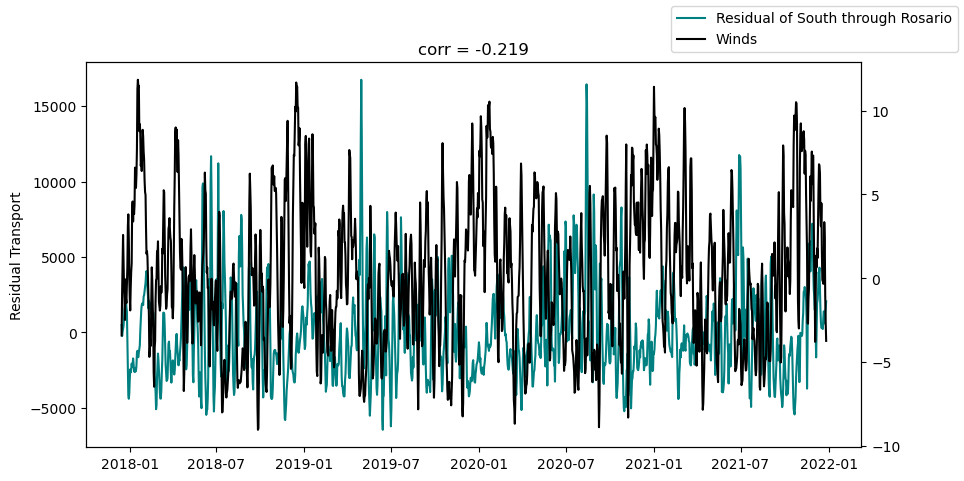

In [43]:
mask = np.isin(datelist_winds,date_rossh)
date_winds_sh = np.array(datelist_winds)[mask]
winds_sh = y_mean4[mask]

corr,p = stats.spearmanr(winds_sh,res)
corr

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_winds_sh,winds_sh,color='k',label='Winds')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')

In [44]:
# Calculate correlations separately
idx = 379
idx_z1 = 20
idx_z2 = 110
idx_z3 = 220
idx_z4 = 375

ros2south_2018 = rostosouth_2018.dropna()
ros2south_2019 = rostosouth_2019.dropna()
winds_2018 = winds_sh[0:idx]
winds_2019 = winds_sh[idx:]
mask = np.isin(datelist_dens,date2018_rossh)
densdiff_ros_2018 = dens_diff_ros[mask]
densdiff_ros_2019 = densdiff_ros[idx:]
tides_2018 = tides_sh[0:idx]
tides_2019 = tides_sh[idx:]
res_2018 = res[0:idx]
res_2019 = res[idx:]
date_2018 = date_tides_sh[0:idx]
date_2019 = date_tides_sh[idx:]

#Separate ddline for 2018 and 2019

slope,intercept = np.polyfit(densdiff_ros2018,rostosouth_2018.dropna()[0:379],1)
ddline2018 = slope*densdiff_ros2018+intercept
res2018 = rostosouth_2018.dropna()[0:379] - ddline2018
print(slope,intercept)

mask = np.isin(datelist_tides,date2018_rossh)
date_tides_2018sh = np.array(datelist_tides)[mask]
tides2018 = tides.vozocrtx[mask]

mask = np.isin(datelist_winds,date2018_rossh)
date_winds_2018sh = np.array(datelist_winds)[mask]
winds2018 = y_mean4[mask]

slope,intercept = np.polyfit(densdiff_ros2019,rostosouth_2019.dropna(),1)
ddline2019 = slope*densdiff_ros2019+intercept
res2019 = rostosouth_2019.dropna() - ddline2019

mask = np.isin(datelist_tides,date2019_rossh)
date_tides_2019sh = np.array(datelist_tides)[mask]
tides2019 = tides.vozocrtx[mask]

mask = np.isin(datelist_winds,date2019_rossh)
date_winds_2019sh = np.array(datelist_winds)[mask]
winds2019 = y_mean4[mask]


2750.351224256408 -62426.847692377734


(2233.418155943472, -49067.79070245957)

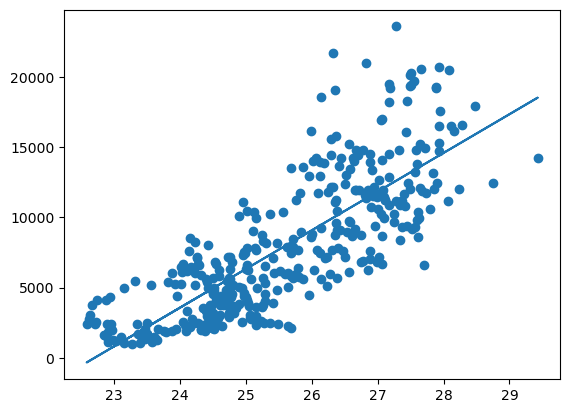

In [45]:
plt.scatter(densdiff_ros2018,rostosouth_2018.dropna()[0:379])
plt.plot(densdiff_ros2018,ddline2018)
slope,intercept

In [46]:
print('----- 2018 Correlations -----')

corr,p = stats.spearmanr(densdiff_ros_2018,ros2south_2018)
print('Densdiff and Ros:',corr)
corr,p = stats.spearmanr(tides2018,res2018)
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2018,res2018)
print('Winds and Ros:',corr)
corr,p = stats.spearmanr(tides2018,res2018)
print('Tides and Ros (2018):',corr)


print('\n        --- Zone 1 ---')
corr,p = stats.spearmanr(tides2018[idx_z1:idx_z2],res2018[idx_z1:idx_z2])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2018[idx_z1:idx_z2],res2018[idx_z1:idx_z2])
print('Winds and Ros:',corr)
print('\n        --- Zone 2 ---')
corr,p = stats.spearmanr(tides2018[idx_z2:idx_z3],res2018[idx_z2:idx_z3])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2018[idx_z2:idx_z3],res2018[idx_z2:idx_z3])
print('Winds and Ros:',corr)
print('\n        --- Zone 3 ---')
corr,p = stats.spearmanr(tides2018[idx_z3:idx_z4],res2018[idx_z3:idx_z4])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2018[idx_z3:idx_z4],res2018[idx_z3:idx_z4])
print('Winds and Ros:',corr)
# print('\n        --- Zone 4 ---')
# corr,p = stats.spearmanr(tides2018[idx_z4:],res2018[idx_z4:])
# print('Tides and Ros:',corr)
# corr,p = stats.spearmanr(winds2018[idx_z4:],res2018[idx_z4:])
# print('Winds and Ros:',corr)


print('\n ----- 2019 Correlations -----')

corr,p = stats.spearmanr(densdiff_ros2019,ros2south_2019.dropna())
print('Densdiff and Ros:',corr)
corr,p = stats.spearmanr(tides2019,res2019)
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2019,res2019)
print('Winds and Ros:',corr)
corr,p = stats.spearmanr(tides2019,res2019)
print('Tides and Ros:',corr)

print('\n        --- Zone 1 ---')
corr,p = stats.spearmanr(tides2019[idx_z1:idx_z2],res2019[idx_z1:idx_z2])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2019[idx_z1:idx_z2],res2019[idx_z1:idx_z2])
print('Winds and Ros:',corr)
print('\n        --- Zone 2 ---')
corr,p = stats.spearmanr(tides2019[idx_z2:idx_z3],res2019[idx_z2:idx_z3])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2019[idx_z2:idx_z3],res2019[idx_z2:idx_z3])
print('Winds and Ros:',corr)
print('\n        --- Zone 3 ---')
corr,p = stats.spearmanr(tides2019[idx_z3:idx_z4],res2019[idx_z3:idx_z4])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2019[idx_z3:idx_z4],res2019[idx_z3:idx_z4])
print('Winds and Ros:',corr)
# print('\n        --- Zone 4 ---')
# corr,p = stats.spearmanr(tides2019[idx_z4:],res2019[idx_z4:])
# print('Tides and Ros:',corr)
# corr,p = stats.spearmanr(winds2019[idx_z4:],res2019[idx_z4:])
# print('Winds and Ros:',corr)

----- 2018 Correlations -----
Densdiff and Ros: 0.8292558573214036
Tides and Ros: -0.12447301190531297
Winds and Ros: -0.19575566003839853
Tides and Ros (2018): -0.12447301190531297

        --- Zone 1 ---
Tides and Ros: 0.002131950446557188
Winds and Ros: 0.22197802197802197

        --- Zone 2 ---
Tides and Ros: -0.031724635394360164
Winds and Ros: -0.10798638505060525

        --- Zone 3 ---
Tides and Ros: -0.2865263768489575
Winds and Ros: -0.37040701234249623

 ----- 2019 Correlations -----
Densdiff and Ros: 0.7061271358887469
Tides and Ros: -0.2131397691377052
Winds and Ros: -0.2873803439062376
Tides and Ros: -0.2131397691377052

        --- Zone 1 ---
Tides and Ros: -0.1223278594065111
Winds and Ros: -0.22482611021936866

        --- Zone 2 ---
Tides and Ros: -0.34277663818948223
Winds and Ros: -0.22409214886279105

        --- Zone 3 ---
Tides and Ros: -0.18215439095250568
Winds and Ros: -0.4337884512275715


In [47]:
## With Rosario Tides

#Separate ddline for 2018 and 2019

mask = np.isin(datelist_tides,date2018_rossh)
date_tides_2018sh = np.array(datelist_tides)[mask]
tides2018 = tides_ros.vozocrtx[mask]

mask = np.isin(datelist_tides,date2019_rossh)
date_tides_2019sh = np.array(datelist_tides)[mask]
tides2019 = tides_ros.vozocrtx[mask]

print('----- 2018 Correlations -----')

corr,p = stats.spearmanr(densdiff_ros_2018,ros2south_2018)
print('Densdiff and Ros:',corr)
corr,p = stats.spearmanr(tides2018,res2018)
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2018,res2018)
print('Winds and Ros:',corr)
corr,p = stats.spearmanr(tides2018,res2018)
print('Tides and Ros (2018):',corr)


print('\n        --- Zone 1 ---')
corr,p = stats.spearmanr(tides2018[idx_z1:idx_z2],res2018[idx_z1:idx_z2])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2018[idx_z1:idx_z2],res2018[idx_z1:idx_z2])
print('Winds and Ros:',corr)
print('\n        --- Zone 2 ---')
corr,p = stats.spearmanr(tides2018[idx_z2:idx_z3],res2018[idx_z2:idx_z3])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2018[idx_z2:idx_z3],res2018[idx_z2:idx_z3])
print('Winds and Ros:',corr)
print('\n        --- Zone 3 ---')
corr,p = stats.spearmanr(tides2018[idx_z3:idx_z4],res2018[idx_z3:idx_z4])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2018[idx_z3:idx_z4],res2018[idx_z3:idx_z4])
print('Winds and Ros:',corr)
print('\n        --- Zone 4 ---')
corr,p = stats.spearmanr(tides2018[idx_z4:],res2018[idx_z4:])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2018[idx_z4:],res2018[idx_z4:])
print('Winds and Ros:',corr)


print('\n ----- 2019 Correlations -----')

corr,p = stats.spearmanr(densdiff_ros2019,ros2south_2019.dropna())
print('Densdiff and Ros:',corr)
corr,p = stats.spearmanr(tides2019,res2019)
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2019,res2019)
print('Winds and Ros:',corr)
corr,p = stats.spearmanr(tides2019,res2019)
print('Tides and Ros:',corr)

print('\n        --- Zone 1 ---')
corr,p = stats.spearmanr(tides2019[idx_z1:idx_z2],res2019[idx_z1:idx_z2])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2019[idx_z1:idx_z2],res2019[idx_z1:idx_z2])
print('Winds and Ros:',corr)
print('\n        --- Zone 2 ---')
corr,p = stats.spearmanr(tides2019[idx_z2:idx_z3],res2019[idx_z2:idx_z3])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2019[idx_z2:idx_z3],res2019[idx_z2:idx_z3])
print('Winds and Ros:',corr)
print('\n        --- Zone 3 ---')
corr,p = stats.spearmanr(tides2019[idx_z3:idx_z4],res2019[idx_z3:idx_z4])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2019[idx_z3:idx_z4],res2019[idx_z3:idx_z4])
print('Winds and Ros:',corr)
print('\n        --- Zone 4 ---')
corr,p = stats.spearmanr(tides2019[idx_z4:],res2019[idx_z4:])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds2019[idx_z4:],res2019[idx_z4:])
print('Winds and Ros:',corr)

----- 2018 Correlations -----
Densdiff and Ros: 0.8292558573214036
Tides and Ros: -0.009632260069699314
Winds and Ros: -0.19575566003839853
Tides and Ros (2018): -0.009632260069699314

        --- Zone 1 ---
Tides and Ros: -0.037922377248219945
Winds and Ros: 0.22197802197802197

        --- Zone 2 ---
Tides and Ros: -0.008326758785474382
Winds and Ros: -0.10798638505060525

        --- Zone 3 ---
Tides and Ros: -0.08834069156649801
Winds and Ros: -0.37040701234249623

        --- Zone 4 ---
Tides and Ros: -0.7999999999999999
Winds and Ros: 1.0

 ----- 2019 Correlations -----
Densdiff and Ros: 0.7061271358887469
Tides and Ros: -0.12790642158032944
Winds and Ros: -0.2873803439062376
Tides and Ros: -0.12790642158032944

        --- Zone 1 ---
Tides and Ros: -0.10002057867226406
Winds and Ros: -0.22482611021936866

        --- Zone 2 ---
Tides and Ros: -0.3751189053941348
Winds and Ros: -0.22409214886279105

        --- Zone 3 ---
Tides and Ros: -0.028516565044451932
Winds and Ros: -0.433

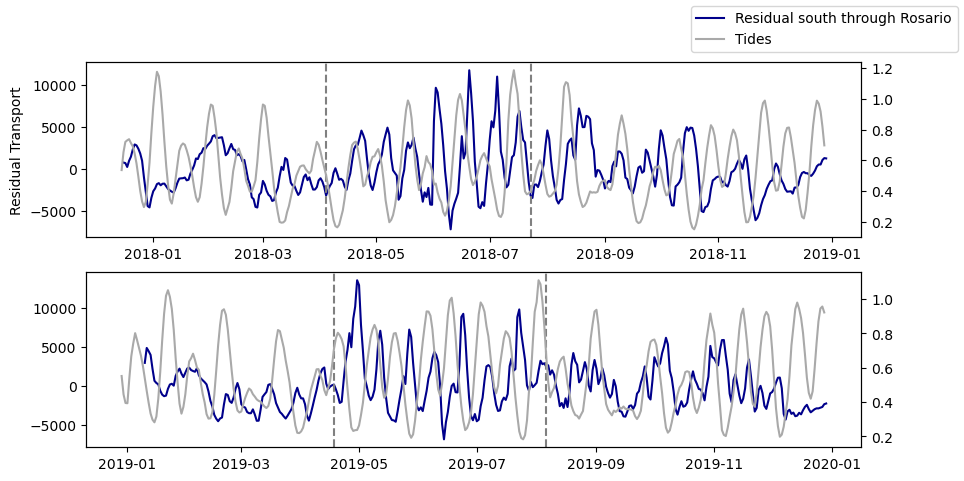

In [48]:
fig,ax = plt.subplots(2,1,figsize=(10,5))
ax2 = ax[0].twinx()
ax2.plot(date_2018,tides_2018,color='darkgrey',label='Tides')
ax[0].set_ylabel('Residual Transport')
# ax.plot(rostosouth.dropna(),label='Transport south through Rosario')
ax[0].plot(res2018,label='Residual south through Rosario',color='darkblue')
ax[0].axvline(date_tides_sh[110],ls='--',color='grey')
ax[0].axvline(date_tides_sh[220],ls='--',color='grey')
# ax[0].axvline(date_tides_sh[300],ls='--',color='grey')
ax3 = ax[1].twinx()
ax3.plot(date_2019[:365],tides_2019[:365],color='darkgrey')
ax[1].plot(res2019,color='darkblue')
ax[1].axvline(date_2019[110],ls='--',color='grey')
ax[1].axvline(date_2019[220],ls='--',color='grey')
# ax[1].axvline(date_2019[300],ls='--',color='grey')
fig.legend()

In [49]:
stats.spearmanr(tides_2019[110:240],res_2019[110:240]),stats.spearmanr(tides_2018[110:240],res_2018[110:240])

(SignificanceResult(statistic=-0.29959442297450467, pvalue=0.0005345796211268355),
 SignificanceResult(statistic=-0.057488153600349576, pvalue=0.515903605437603))

In [50]:
#Residual calculated based on fit to entire time series

print('----- 2018 Correlations -----')

corr,p = stats.spearmanr(densdiff_ros_2018,ros2south_2018)
print('Densdiff and Ros:',corr)
corr,p = stats.spearmanr(tides_2018,res_2018)
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2018,res_2018)
print('Winds and Ros:',corr)
corr,p = stats.spearmanr(tides_2018,res_2018)
print('Tides and Ros (2018):',corr)


print('\n        --- Zone 1 ---')
corr,p = stats.spearmanr(tides_2018[idx_z1:idx_z2],res_2018[idx_z1:idx_z2])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2018[idx_z1:idx_z2],res_2018[idx_z1:idx_z2])
print('Winds and Ros:',corr)
print('\n        --- Zone 2 ---')
corr,p = stats.spearmanr(tides_2018[idx_z2:idx_z3],res_2018[idx_z2:idx_z3])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2018[idx_z2:idx_z3],res_2018[idx_z2:idx_z3])
print('Winds and Ros:',corr)
print('\n        --- Zone 3 ---')
corr,p = stats.spearmanr(tides_2018[idx_z3:idx_z4],res_2018[idx_z3:idx_z4])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2018[idx_z3:idx_z4],res_2018[idx_z3:idx_z4])
print('Winds and Ros:',corr)
# print('\n        --- Zone 4 ---')
# corr,p = stats.spearmanr(tides2018[idx_z4:],res2018[idx_z4:])
# print('Tides and Ros:',corr)
# corr,p = stats.spearmanr(winds2018[idx_z4:],res2018[idx_z4:])
# print('Winds and Ros:',corr)


print('\n ----- 2019 Correlations -----')

corr,p = stats.spearmanr(densdiff_ros2019,ros2south_2019.dropna())
print('Densdiff and Ros:',corr)
corr,p = stats.spearmanr(tides_2019,res_2019)
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2019,res_2019)
print('Winds and Ros:',corr)
corr,p = stats.spearmanr(tides_2019,res_2019)
print('Tides and Ros:',corr)

print('\n        --- Zone 1 ---')
corr,p = stats.spearmanr(tides_2019[idx_z1:idx_z2],res_2019[idx_z1:idx_z2])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2019[idx_z1:idx_z2],res_2019[idx_z1:idx_z2])
print('Winds and Ros:',corr)
print('\n        --- Zone 2 ---')
corr,p = stats.spearmanr(tides_2019[idx_z2:idx_z3],res_2019[idx_z2:idx_z3])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2019[idx_z2:idx_z3],res_2019[idx_z2:idx_z3])
print('Winds and Ros:',corr)
print('\n        --- Zone 3 ---')
corr,p = stats.spearmanr(tides_2019[idx_z3:idx_z4],res_2019[idx_z3:idx_z4])
print('Tides and Ros:',corr)
corr,p = stats.spearmanr(winds_2019[idx_z3:idx_z4],res_2019[idx_z3:idx_z4])
print('Winds and Ros:',corr)
# print('\n        --- Zone 4 ---')
# corr,p = stats.spearmanr(tides2019[idx_z4:],res2019[idx_z4:])
# print('Tides and Ros:',corr)
# corr,p = stats.spearmanr(winds2019[idx_z4:],res2019[idx_z4:])
# print('Winds and Ros:',corr)

----- 2018 Correlations -----
Densdiff and Ros: 0.8292558573214036
Tides and Ros: -0.15787578003936842
Winds and Ros: -0.17776477252938855
Tides and Ros (2018): -0.15787578003936842

        --- Zone 1 ---
Tides and Ros: -0.03622669465366094
Winds and Ros: 0.2576038194015722

        --- Zone 2 ---
Tides and Ros: -0.03204021369158984
Winds and Ros: -0.13761467889908258

        --- Zone 3 ---
Tides and Ros: -0.33463955399439266
Winds and Ros: -0.32162031516870226

 ----- 2019 Correlations -----
Densdiff and Ros: 0.7061271358887469
Tides and Ros: -0.062983418294368
Winds and Ros: -0.2290377543598474
Tides and Ros: -0.062983418294368

        --- Zone 1 ---
Tides and Ros: 0.13133308638926616
Winds and Ros: -0.18333950693501255

        --- Zone 2 ---
Tides and Ros: -0.29063408696436216
Winds and Ros: -0.28313234001307397

        --- Zone 3 ---
Tides and Ros: -0.11336727788340692
Winds and Ros: -0.43107537623666653


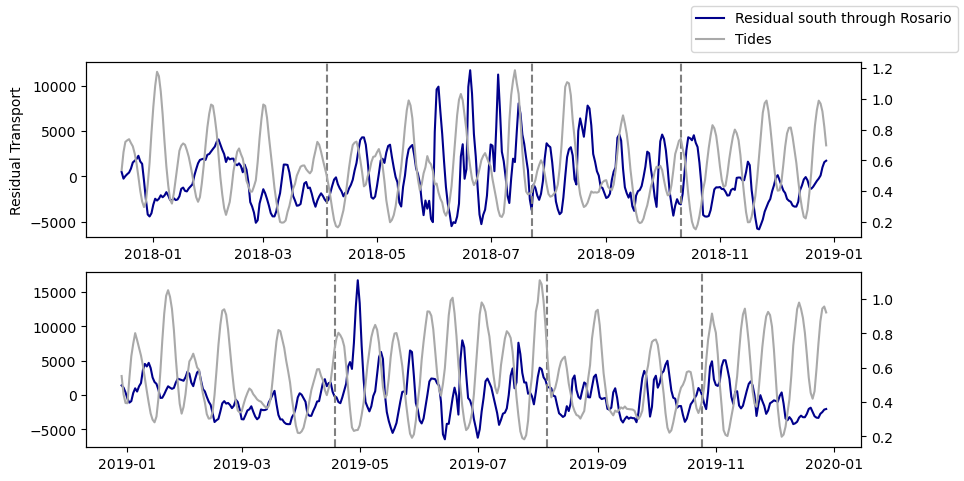

In [51]:
fig,ax = plt.subplots(2,1,figsize=(10,5))
ax2 = ax[0].twinx()
ax2.plot(date_2018,tides_2018,color='darkgrey',label='Tides')
ax[0].set_ylabel('Residual Transport')
# ax.plot(rostosouth.dropna(),label='Transport south through Rosario')
ax[0].plot(res_2018,label='Residual south through Rosario',color='darkblue')
ax[0].axvline(date_tides_sh[110],ls='--',color='grey')
ax[0].axvline(date_tides_sh[220],ls='--',color='grey')
ax[0].axvline(date_tides_sh[300],ls='--',color='grey')
ax3 = ax[1].twinx()
ax3.plot(date_2019[:365],tides_2019[:365],color='darkgrey')
ax[1].plot(res_2019[:365],color='darkblue')
ax[1].axvline(date_2019[110],ls='--',color='grey')
ax[1].axvline(date_2019[220],ls='--',color='grey')
ax[1].axvline(date_2019[300],ls='--',color='grey')
fig.legend()

Plot is starting at 19dec because of shift, not 10dec

2019 almost has more distinct 4 regions ... Look at correlation to see if this is in fact the case. Would almost move 2nd line even more right?

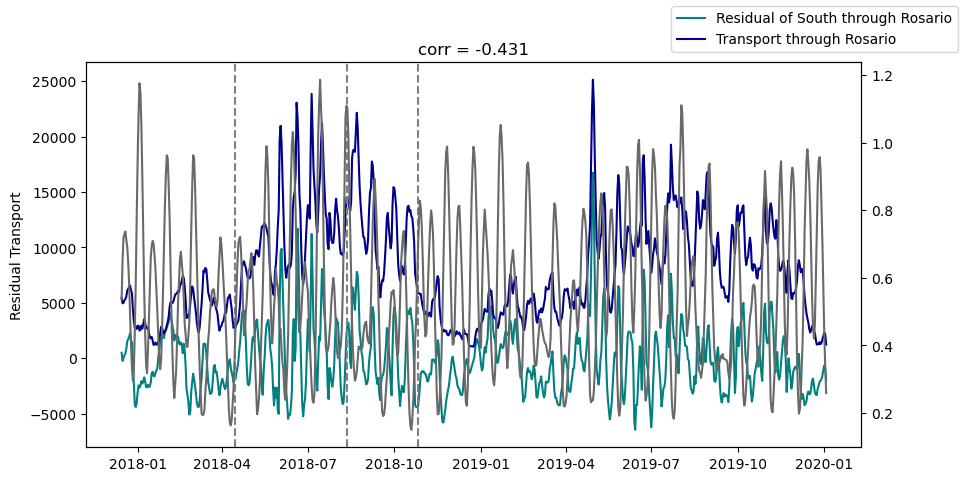

In [52]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res[:750],color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh[:750],tides_sh[:750],color='dimgrey')
ax.plot(rostosouth.dropna()[:750],color='darkblue',label='Transport through Rosario')
# ax.plot(harotosouth.dropna(),color='sienna',label='Transport through Haro')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')
ax.axvline(date_tides_sh[120],ls='--',color='grey')
ax.axvline(date_tides_sh[240],ls='--',color='grey')
ax.axvline(date_tides_sh[315],ls='--',color='grey')

### River Flow

In [53]:
# Import data and take mean

FR_data = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/FR_discharge.csv')
FR_4mean = FR_data['Discharge (m3/s)'].rolling(window=4,center=True).mean()

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)

dates = []
datelist_FR = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_FR.append(date)
    date += dt.timedelta(days=1)

In [54]:
# Add all other runoff from climatology

rivers = xr.open_dataset('/data/SalishSeaCast/rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc')
clim = np.zeros(365)

for river in rivers.data_vars:
    clim += rivers[river][0:]
    
clim -= rivers['fraser']

date = dt.datetime(2020,1,1)
enddate = dt.datetime(2020,12,31)
dates = []
datelist_2020 = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_2020.append(date)
    date += dt.timedelta(days=1)

idx_leap = datelist_2020.index(dt.datetime(2020,2,29))

clim2020 = np.insert(clim,idx_leap,(clim[58]+clim[59])/2)

clim1718 = np.append(clim,clim)
clim1719 = np.append(clim1718,clim)
clim1720 = np.append(clim1719,clim2020)
clim1721 = np.append(clim1720,clim)
clim1722 = np.append(clim1721,clim)
len(clim1722)

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_yrs = []
dates = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_yrs.append(date)
    date += dt.timedelta(days=1)
       
df_FR_4mean = pd.DataFrame(FR_4mean.values,index=datelist_FR)
df_clim = pd.DataFrame(clim1722,index=datelist_yrs)

runoff = df_FR_4mean.add(df_clim, fill_value=0)

In [55]:
mask = np.isin(datelist_FR,date_rossh)
runoff_ros = runoff[mask]
FR_4mean_ros = FR_4mean[mask]

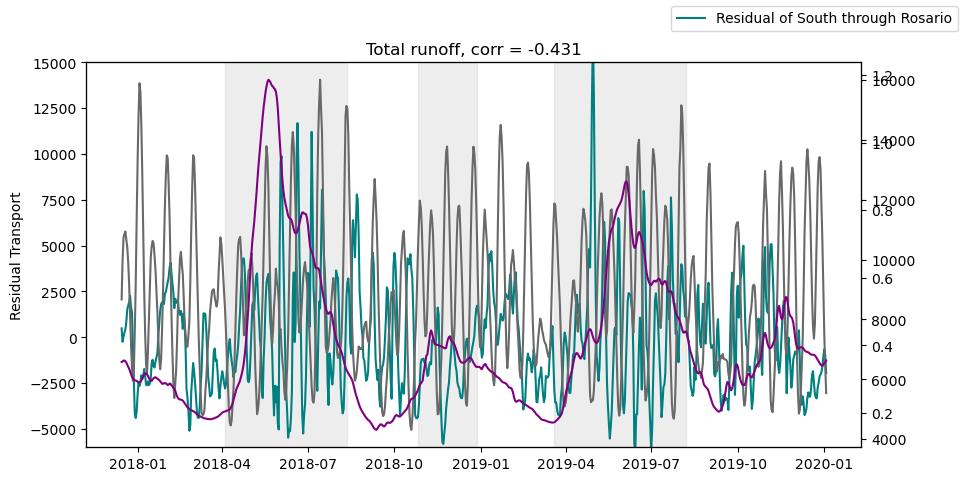

In [56]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res[:750],color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh[:750],tides_sh[:750],color='dimgrey')
# ax.plot(rostosouth.dropna(),color='darkblue',label='Transport through Rosario')
# ax.plot(harotosouth.dropna(),color='sienna',label='Transport through Haro')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'Total runoff, corr = {np.round(corr,3)}')
ax3 = ax.twinx()
ax3.plot(date_rossh[:750],runoff_ros[:750],color='purple')

ax.set_ylim([-6000,15000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_tides_sh[110],x2=date_tides_sh[240],color='lightgrey', alpha=0.4)

ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_tides_sh[315],x2=date_tides_sh[378],color='lightgrey', alpha=0.4)

ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_tides_sh[460],x2=date_tides_sh[600],color='lightgrey', alpha=0.4)


In [57]:
print(stats.spearmanr(tides_sh[:110],res[:110])[0])
print(stats.spearmanr(tides_sh[110:240],res[110:240])[0])
print(stats.spearmanr(tides_sh[240:379],res[240:379])[0])

-0.06566282713071704
-0.057488153600349576
-0.3034183833057777


In [58]:
stats.spearmanr(tides_sh[0:379],res[0:379])[0]

-0.15787578003936842

All negative, mor

Text(0, 0.5, 'Fraser river flow (m3/s)')

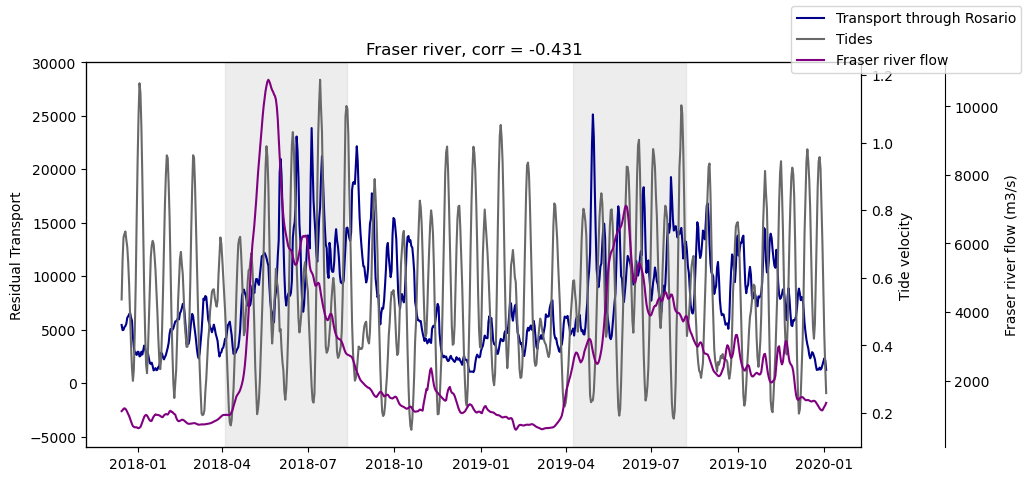

In [59]:
fig,ax = plt.subplots(figsize=(10,5))
# ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh[:750],tides_sh[:750],color='dimgrey',label='Tides')
ax.plot(rostosouth.dropna()[:750],color='darkblue',label='Transport through Rosario')
# ax.plot(harotosouth.dropna(),color='sienna',label='Transport through Haro')

ax.set_ylabel('Residual Transport')
ax.set_title(f'Fraser river, corr = {np.round(corr,3)}')
ax3 = ax.twinx()
ax3.plot(date_rossh[:750],FR_4mean_ros[:750],color='purple',label='Fraser river flow')

ax.set_ylim([-6000,30000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_tides_sh[110],x2=date_tides_sh[240],color='lightgrey', alpha=0.4)
# ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_tides_sh[315],x2=date_tides_sh[378],color='lightgrey', alpha=0.4)
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_tides_sh[480],x2=date_tides_sh[600],color='lightgrey', alpha=0.4)
ax3.spines['right'].set_position(('outward', 60))
fig.legend()
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Fraser river flow (m3/s)')


## Flow to admiralty vs. to VicSill

Look @ if +/- looking the same with 2 year fit, then look at just 2019

0.7898050392182049
0.20985944418237268


Text(0.5, 1.0, 'PR to adm')

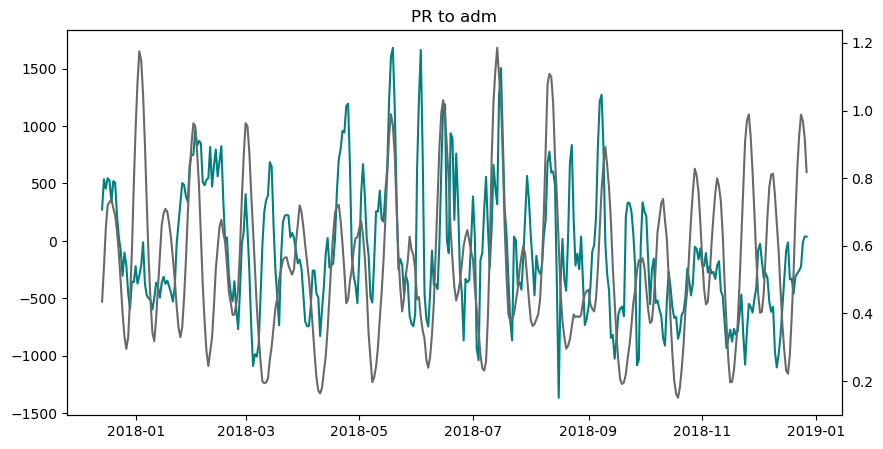

In [60]:
PRtoadm_ros_avg.dropna()
date_prtoadm = list(PRtoadm_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtoadm)
densdiff_prtoadm = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtoadm)
tides_prtoadm = tides.vozocrtx[mask]

corr,p = stats.spearmanr(densdiff_prtoadm,PRtoadm_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtoadm,PRtoadm_ros_avg.dropna(),1)
res_prtoadm = PRtoadm_ros_avg.dropna() - (slope*densdiff_prtoadm+intercept)

print(stats.spearmanr(tides_prtoadm,res_prtoadm)[0])
# print(stats.spearmanr(tides_prtoadm[110:240],PRtoadm_ros_avg.dropna()[110:240])[0])
# print(stats.spearmanr(tides_prtoadm[:110],PRtoadm_ros_avg.dropna()[:110])[0])
# print(stats.spearmanr(tides_prtoadm[240:379],PRtoadm_ros_avg.dropna()[240:379])[0])

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_prtoadm[0:379],color='teal')
ax2 = ax.twinx()
ax2.plot(date_prtoadm[0:379],tides_prtoadm[0:379],color='dimgrey')
ax.set_title('PR to adm')

0.773351192377872
-0.15437219396038987
0.06903549140367886
-0.2826454477830625
-0.3432101523749944


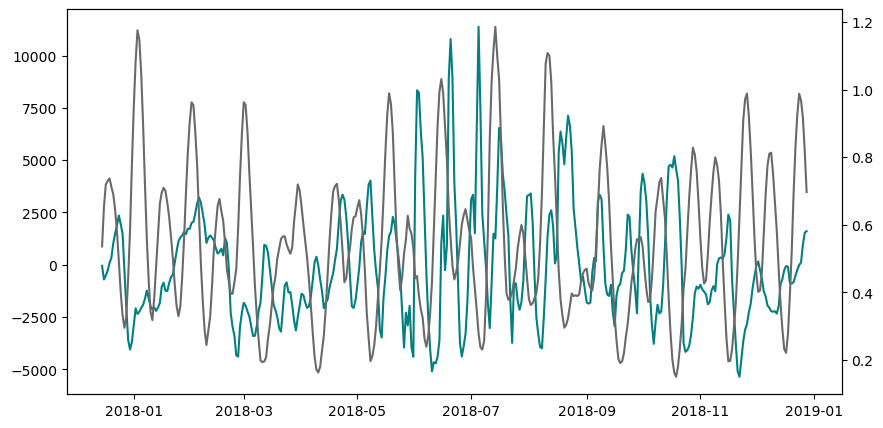

In [61]:
date_prtovs = list(PRtovs_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtovs)
densdiff_prtovs = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtovs)
tides_prtovs = tides.vozocrtx[mask]

corr,p = stats.spearmanr(densdiff_prtovs,PRtovs_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtovs,PRtovs_ros_avg.dropna(),1)
res_prtovs = PRtovs_ros_avg.dropna() - (slope*densdiff_prtovs+intercept)

print(stats.spearmanr(tides_prtovs,PRtovs_ros_avg.dropna())[0])
print(stats.spearmanr(tides_prtovs[110:240],PRtovs_ros_avg.dropna()[110:240])[0])
print(stats.spearmanr(tides_prtovs[:110],PRtovs_ros_avg.dropna()[:110])[0])
print(stats.spearmanr(tides_prtovs[240:379],PRtovs_ros_avg.dropna()[240:379])[0])

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_prtovs[0:379],color='teal')
ax2 = ax.twinx()
ax2.plot(date_prtovs[0:379],tides_prtovs[0:379],color='dimgrey')

0.7956335429603031
-0.18961034953258254
-0.16044190143249257
-0.07077519554583774
-0.30628267572277573


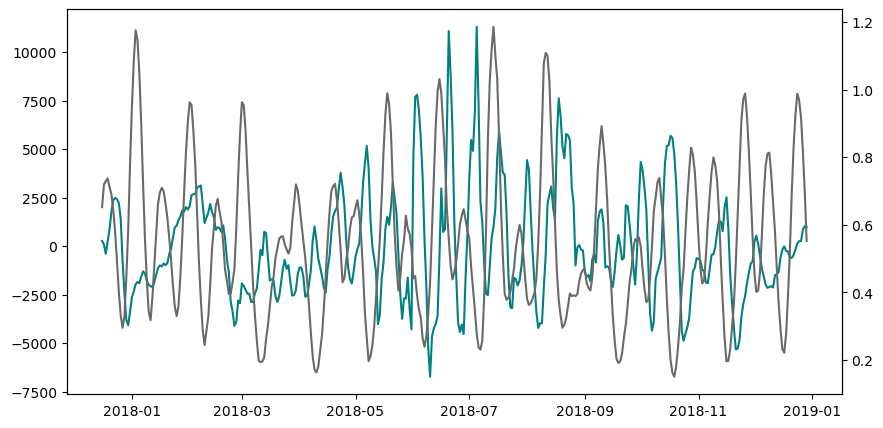

In [62]:
date_prtovs2018 = list(PRtovs2018_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtovs2018)
densdiff_prtovs2018 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtovs2018)
tides_prtovs2018 = tides.vozocrtx[mask]

corr,p = stats.spearmanr(densdiff_prtovs2018,PRtovs2018_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtovs2018,PRtovs2018_ros_avg.dropna(),1)
res_prtovs2018 = PRtovs2018_ros_avg.dropna() - (slope*densdiff_prtovs2018+intercept)

print(stats.spearmanr(tides_prtovs2018,res_prtovs2018)[0])
print(stats.spearmanr(tides_prtovs2018[110:240],res_prtovs2018[110:240])[0])
print(stats.spearmanr(tides_prtovs2018[:110],res_prtovs2018[:110])[0])
print(stats.spearmanr(tides_prtovs2018[240:379],res_prtovs2018[240:379])[0])

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_prtovs2018,color='teal')
ax2 = ax.twinx()
ax2.plot(date_prtovs2018[0:379],tides_prtovs2018[0:379],color='dimgrey')

0.6712197006069938
-0.1960055898138785
-0.3517977850305207
-0.08886234023848702
-0.1937899471316973


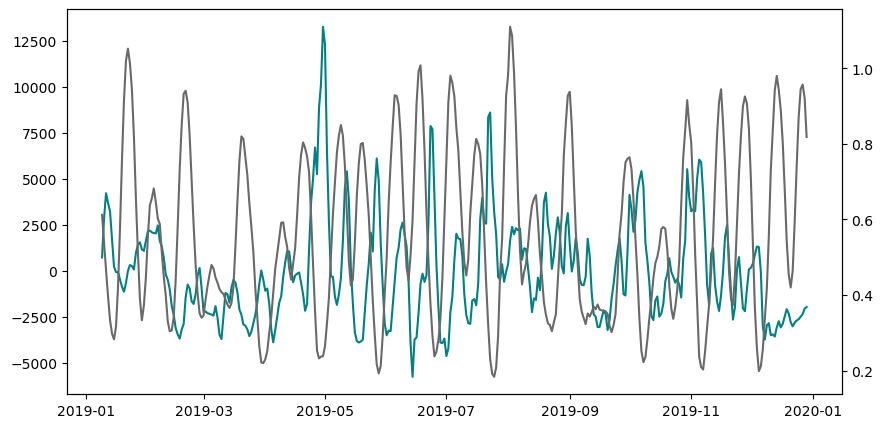

In [63]:
date_prtovs2019 = list(PRtovs2019_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtovs2019)
densdiff_prtovs2019 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtovs2019)
tides_prtovs2019 = tides.vozocrtx[mask]

corr,p = stats.spearmanr(densdiff_prtovs2019,PRtovs2019_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtovs2019,PRtovs2019_ros_avg.dropna(),1)
res_prtovs2019 = PRtovs2019_ros_avg.dropna() - (slope*densdiff_prtovs2019+intercept)

print(stats.spearmanr(tides_prtovs2019,res_prtovs2019)[0])
print(stats.spearmanr(tides_prtovs2019[110:240],res_prtovs2019[110:240])[0])
print(stats.spearmanr(tides_prtovs2019[:110],res_prtovs2019[:110])[0])
print(stats.spearmanr(tides_prtovs2019[240:379],res_prtovs2019[240:379])[0])

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_prtovs2019,color='teal')
ax2 = ax.twinx()
ax2.plot(date_prtovs2019[0:379],tides_prtovs2019[0:379],color='dimgrey')

In [183]:
mask = np.isin(datelist_winds,date_prtovs2018)
winds_prtovs2018 = y_mean4[mask]
mask = np.isin(datelist_winds,date_prtovs2019)
winds_prtovs2019 = y_mean4[mask]

date_prtovs2020 = list(PRtovs2020_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtovs2020)
densdiff_prtovs2020 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtovs2020)
tides_prtovs2020 = tides.vozocrtx[mask]

mask = np.isin(datelist_winds,date_prtovs2020)
winds_prtovs2020 = y_mean4[mask]

corr,p = stats.spearmanr(densdiff_prtovs2020,PRtovs2020_ros_avg.dropna())
print(corr)

slope,intercept = np.polyfit(densdiff_prtovs2020,PRtovs2020_ros_avg.dropna(),1)
res_prtovs2020 = PRtovs2020_ros_avg.dropna() - (slope*densdiff_prtovs2020+intercept)

date_prtovs2021 = list(PRtovs2021_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtovs2021)
densdiff_prtovs2021 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtovs2021)
tides_prtovs2021 = tides.vozocrtx[mask]

mask = np.isin(datelist_winds,date_prtovs2021)
winds_prtovs2021 = y_mean4[mask]

corr,p = stats.spearmanr(densdiff_prtovs2021,PRtovs2021_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtovs2021,PRtovs2021_ros_avg.dropna(),1)
res_prtovs2021 = PRtovs2021_ros_avg.dropna() - (slope*densdiff_prtovs2021+intercept)

0.749523475430906
0.7533198316076914


Look @ this for adm in 2019 and see if that correlation is stronger than 2018

0.828432932767059
0.33405802163537945
0.5629163309617775
0.17896445235894778
0.2820099200142991


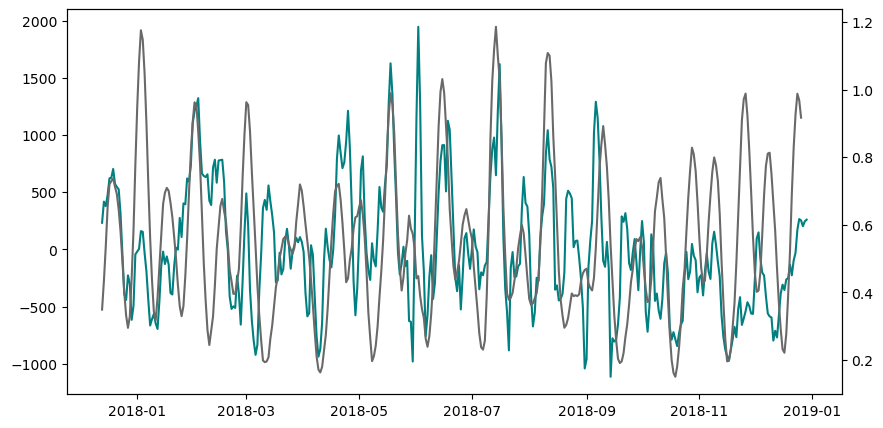

In [65]:
date_prtoadm2018 = list(PRtoadm2018_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtoadm2018)
densdiff_prtoadm2018 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtoadm2018)
tides_prtoadm2018 = tides.vozocrtx[mask]

corr,p = stats.spearmanr(densdiff_prtoadm2018,PRtoadm2018_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtoadm2018,PRtoadm2018_ros_avg.dropna(),1)
res_prtoadm2018 = PRtoadm2018_ros_avg.dropna() - (slope*densdiff_prtoadm2018+intercept)

print(stats.spearmanr(tides_prtoadm2018,res_prtoadm2018)[0])
print(stats.spearmanr(tides_prtoadm2018[110:240],res_prtoadm2018[110:240])[0])
print(stats.spearmanr(tides_prtoadm2018[:110],res_prtoadm2018[:110])[0])
print(stats.spearmanr(tides_prtoadm2018[240:379],res_prtoadm2018[240:379])[0])

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_prtoadm2018,color='teal')
ax2 = ax.twinx()
ax2.plot(date_prtoadm2018[0:379],tides_prtoadm2018[0:379],color='dimgrey')

0.692132571682073
-0.15347723736184815
-0.25645304455884965
-0.16283389310912244
-0.17858285575423746


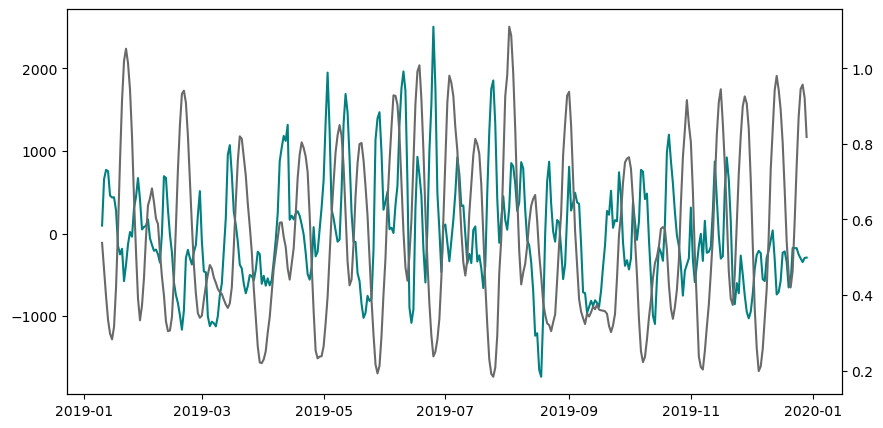

In [66]:
date_prtoadm2019 = list(PRtoadm2019_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtoadm2019)
densdiff_prtoadm2019 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtoadm2019)
tides_prtoadm2019 = tides.vozocrtx[mask]

corr,p = stats.spearmanr(densdiff_prtoadm2019,PRtoadm2019_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtoadm2019,PRtoadm2019_ros_avg.dropna(),1)
res_prtoadm2019 = PRtoadm2019_ros_avg.dropna() - (slope*densdiff_prtoadm2019+intercept)

print(stats.spearmanr(tides_prtoadm2019,res_prtoadm2019)[0])
print(stats.spearmanr(tides_prtoadm2019[110:240],res_prtoadm2019[110:240])[0])
print(stats.spearmanr(tides_prtoadm2019[:110],res_prtoadm2019[:110])[0])
print(stats.spearmanr(tides_prtoadm2019[240:379],res_prtoadm2019[240:379])[0])

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_prtoadm2019,color='teal')
ax2 = ax.twinx()
ax2.plot(date_prtoadm2019[0:379],tides_prtoadm2019[0:379],color='dimgrey')

In [185]:
mask = np.isin(datelist_winds,date_prtoadm2018)
winds_prtoadm2018 = y_mean4[mask]
mask = np.isin(datelist_winds,date_prtoadm2019)
winds_prtoadm2019 = y_mean4[mask]

date_prtoadm2020 = list(PRtoadm2020_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtoadm2020)
densdiff_prtoadm2020 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtoadm2020)
tides_prtoadm2020 = tides.vozocrtx[mask]

mask = np.isin(datelist_winds,date_prtoadm2020)
winds_prtoadm2020 = y_mean4[mask]

corr,p = stats.spearmanr(densdiff_prtoadm2020,PRtoadm2020_ros_avg.dropna())
print(corr)

slope,intercept = np.polyfit(densdiff_prtoadm2020,PRtoadm2020_ros_avg.dropna(),1)
res_prtoadm2020 = PRtoadm2020_ros_avg.dropna() - (slope*densdiff_prtoadm2020+intercept)

date_prtoadm2021 = list(PRtoadm2021_ros_avg.dropna().index)

mask = np.isin(datelist_dens,date_prtoadm2021)
densdiff_prtoadm2021 = dens_diff_ros[mask]

mask = np.isin(datelist_tides,date_prtoadm2021)
tides_prtoadm2021 = tides.vozocrtx[mask]

mask = np.isin(datelist_winds,date_prtoadm2021)
winds_prtoadm2021 = y_mean4[mask]

corr,p = stats.spearmanr(densdiff_prtoadm2021,PRtoadm2021_ros_avg.dropna())
print(corr)
slope,intercept = np.polyfit(densdiff_prtoadm2021,PRtoadm2021_ros_avg.dropna(),1)
res_prtoadm2021 = PRtoadm2021_ros_avg.dropna() - (slope*densdiff_prtoadm2021+intercept)

0.7469843479419691
0.7651535639708786


Text(0, 0.5, 'Tide velocity')

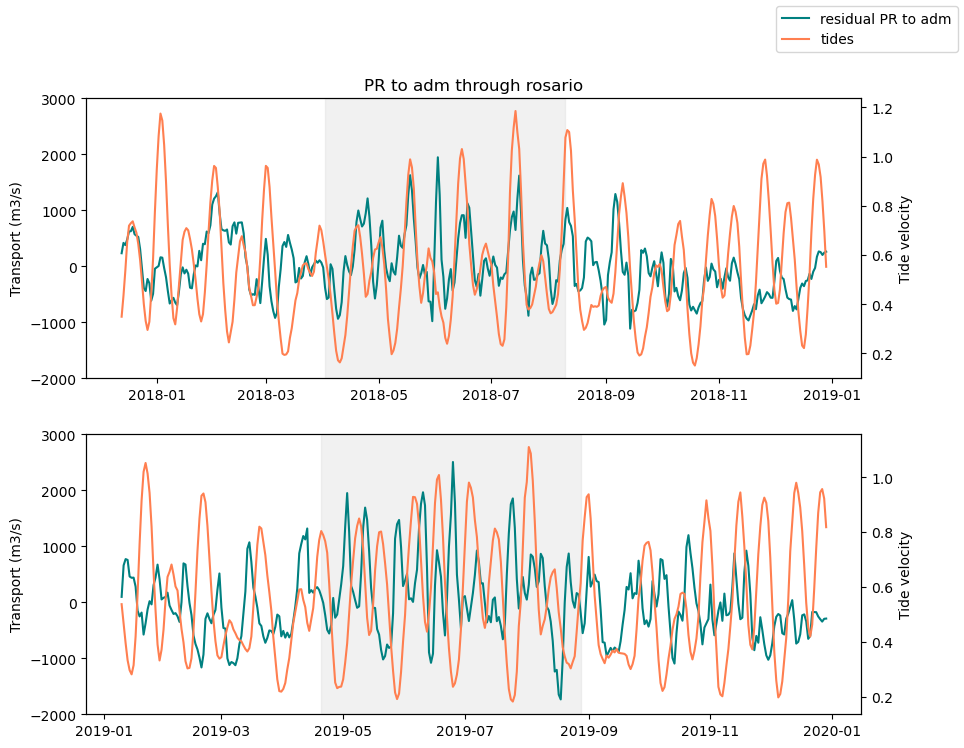

In [67]:
fig,[ax,ax4] = plt.subplots(2,1,figsize=(10,8))

ax.plot(res_prtoadm2018,color='teal',label='residual PR to adm')
ax2 = ax.twinx()
ax2.plot(date_prtoadm2018,tides_prtoadm2018,color='coral',label='tides')
# ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
# ax3.plot(date_harosh[0:379],FR_haro[0:379],color='purple',label='river flow')
ax.set_title(f'PR to adm through rosario')
ax.set_ylim([-2000,3000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2018[110],x2=date_prtoadm2018[240],color='lightgrey', alpha=0.3)
# ax3.spines['right'].set_position(('outward', 60))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
# ax3.set_ylabel('Fraser river flow')
fig.legend()
ax4.plot(res_prtoadm2019,color='teal')
ax42 = ax4.twinx()
ax42.plot(date_prtoadm2019[0:379],tides_prtoadm2019[0:379],color='coral')
# ax43 = ax4.twinx()
# ax3.plot(haro_btrop,color='coral')
# ax43.plot(date_harosh[379:],FR_haro[379:],color='purple')
# ax4.set_title('Haro')
ax4.set_ylim([-2000,3000])
ax4.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2019[100],x2=date_prtoadm2019[230],color='lightgrey', alpha=0.3)
# ax43.spines['right'].set_position(('outward', 60))
ax4.set_ylabel('Transport (m3/s)')
ax42.set_ylabel('Tide velocity')
# ax43.set_ylabel('Fraser river flow')

In [68]:
corr,p = stats.spearmanr(tides_prtoadm2018[110:240],res_prtoadm2018[110:240])
print(corr)
corr,p = stats.spearmanr(tides_prtoadm2019[100:230],res_prtoadm2019[100:230])
print(corr)

0.5629163309617775
-0.22638845266219668


Text(0, 0.5, 'Age (hr)')

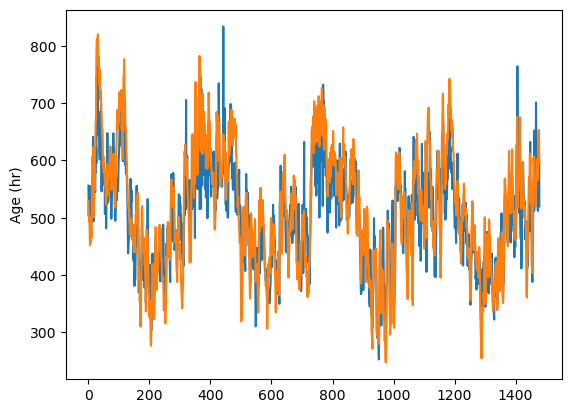

In [69]:
plt.plot(age_2018['forpr_ros3'][2],label='PR to adm')
plt.plot(age_2018['forpr_ros3'][4],label='PR to vicsill')
# plt.plot(age_2018['backvs_ros3'][4])
# plt.plot(age_2018['backadm_ros3'][4])
plt.ylabel('Age (hr)')

Look @ with winds

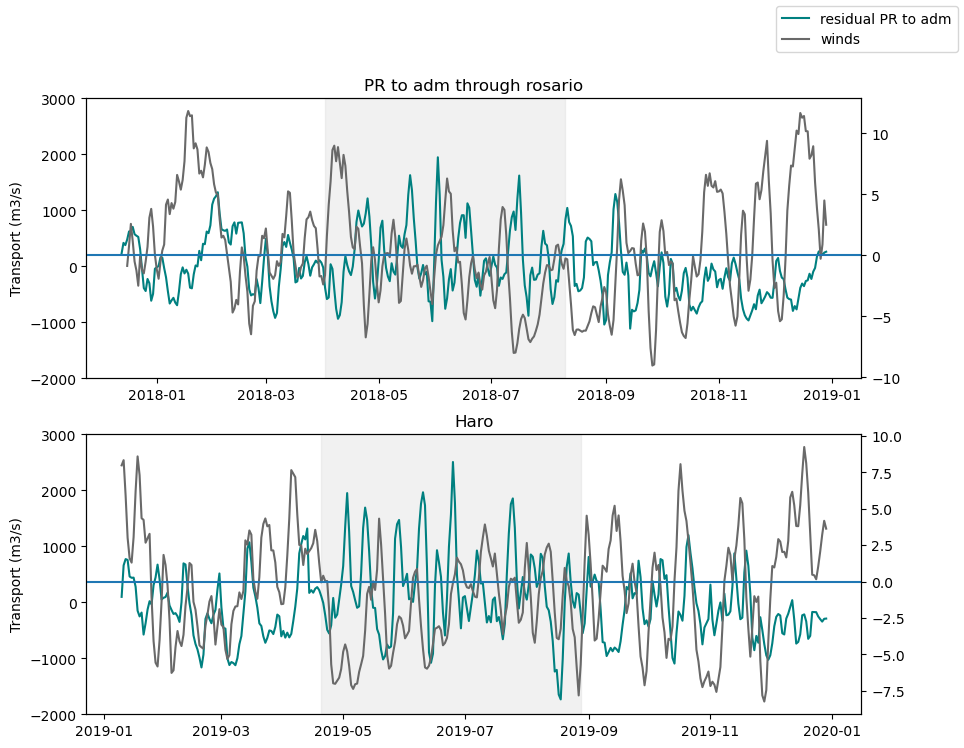

In [109]:
fig,[ax,ax4] = plt.subplots(2,1,figsize=(10,8))

ax.plot(res_prtoadm2018,color='teal',label='residual PR to adm')
# ax2 = ax.twinx()
# ax2.plot(date_prtoadm2018,tides_prtoadm2018,color='coral',label='tides')
ax3 = ax.twinx()
ax3.plot(date_winds_2018sh,winds2018,color='dimgrey',label='winds')
# ax3.plot(haro_btrop,color='coral')
# ax3.plot(date_harosh[0:379],FR_haro[0:379],color='purple',label='river flow')
ax.set_title(f'PR to adm through rosario')
ax.set_ylim([-2000,3000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2018[110],x2=date_prtoadm2018[240],color='lightgrey', alpha=0.3)
# ax3.spines['right'].set_position(('outward', 60))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
# ax3.set_ylabel('Fraser river flow')
fig.legend()
ax4.plot(res_prtoadm2019,color='teal')
# ax42 = ax4.twinx()
# ax42.plot(date_prtoadm2019[0:379],tides_prtoadm2019[0:379],color='coral')
ax43 = ax4.twinx()
# ax3.plot(haro_btrop,color='coral')
ax43.plot(date_winds_2019sh,winds2019,color='dimgrey')
# ax43.plot(date_harosh[379:],FR_haro[379:],color='purple')
ax4.set_title('Haro')
ax4.set_ylim([-2000,3000])
ax4.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2019[100],x2=date_prtoadm2019[230],color='lightgrey', alpha=0.3)
# ax43.spines['right'].set_position(('outward', 60))
ax4.set_ylabel('Transport (m3/s)')
ax42.set_ylabel('Tide velocity')
# ax43.set_ylabel('Fraser river flow')
ax3.axhline(0)
ax43.axhline(0)

In [191]:
print('-- PR to adm --')
corr,p = stats.spearmanr(res_prtoadm2018[113:243],winds_prtoadm2018[100:230])
print('2018:',corr)
corr,p = stats.spearmanr(res_prtoadm2019[100:230],winds_prtoadm2019[100:230])
print('2019',corr)
corr,p = stats.spearmanr(res_prtoadm2020[100:230],winds_prtoadm2020[100:230])
print('2020',corr)
corr,p = stats.spearmanr(res_prtoadm2021[100:230],winds_prtoadm2021[100:230])
print('2021',corr)

print('-- PR to vs --')
corr,p = stats.spearmanr(res_prtovs2018[113:243],winds_prtovs2018[100:230])
print('2018:',corr)
corr,p = stats.spearmanr(res_prtovs2019[100:230],winds_prtovs2019[100:230])
print('2019',corr)
corr,p = stats.spearmanr(res_prtovs2020[100:230],winds_prtovs2020[100:230])
print('2020',corr)
corr,p = stats.spearmanr(res_prtovs2021[100:230],winds_prtovs2021[100:230])
print('2021',corr)

-- PR to adm --
2018: 0.11326387087082986
2019 -0.02935175954881263
2020 -0.2006117794862691
2021 -0.20182987614196563
-- PR to vs --
2018: 0.24862008220786846
2019 -0.3121195154924961
2020 -0.4040503079381119
2021 -0.3564789905638476


#### Look at 2020 and 2021

-0.057488153600349576
-0.24475822420079474
-0.1524272518924925
-0.18715188554760742


Text(0, 0.5, 'Fraser river flow')

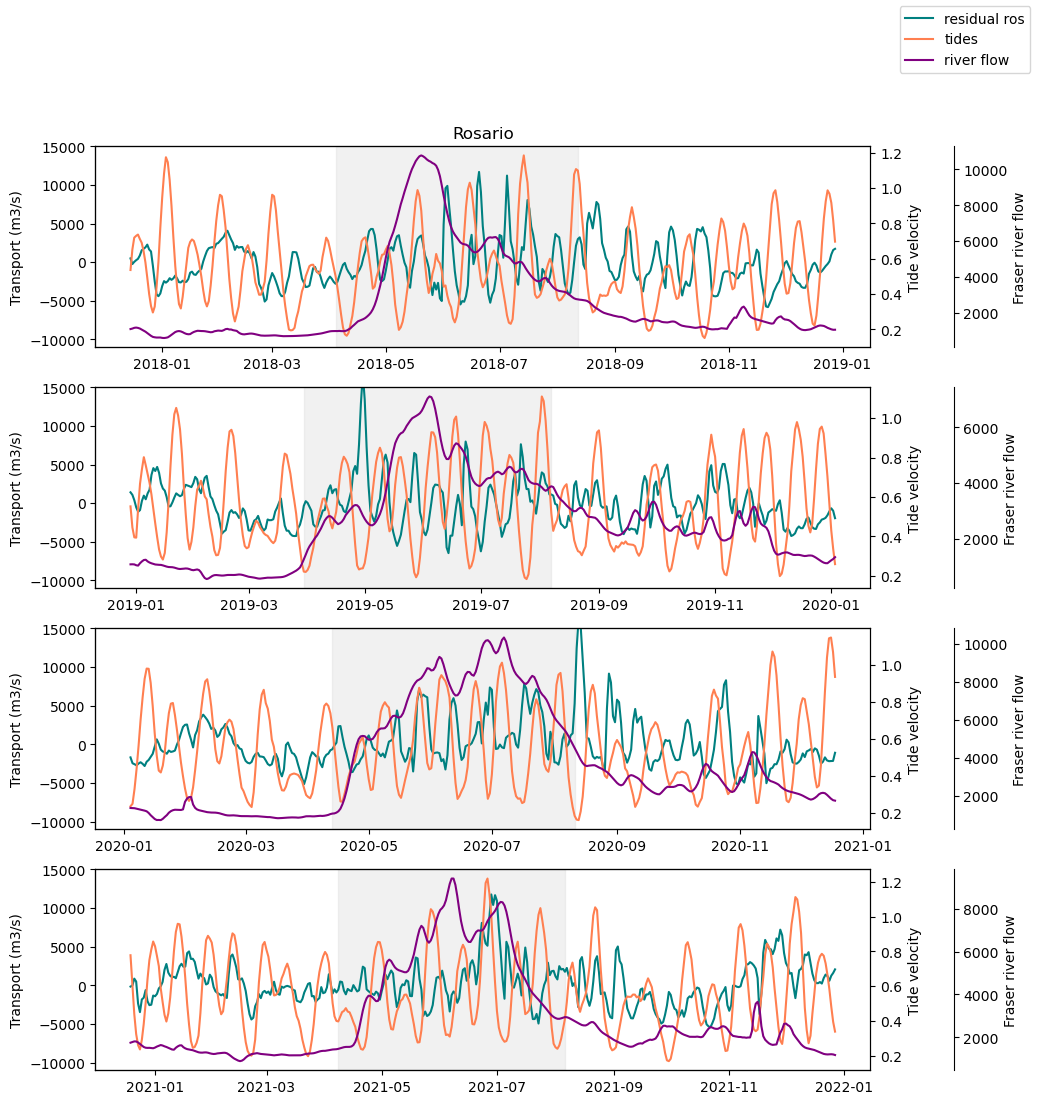

In [72]:
mask = np.isin(datelist_yrs,date_rossh)
FR_haro = FR_4mean[mask]

corr,p = stats.spearmanr(tides_sh[110:240],res[110:240])
print(corr)
corr,p = stats.spearmanr(tides_sh[470:600],res[470:600])
print(corr)
corr,p = stats.spearmanr(tides_sh[850:970],res[850:970])
print(corr)
corr,p = stats.spearmanr(tides_sh[1210:1330],res[1210:1330])
print(corr)

fig,[ax,ax4,ax5,ax6] = plt.subplots(4,1,figsize=(10,12))

ax.plot(res[0:379],color='teal',label='residual ros')
ax2 = ax.twinx()
ax2.plot(date_rossh[0:379],tides_sh[0:379],color='coral',label='tides')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_rossh[0:379],FR_haro[0:379],color='purple',label='river flow')
ax.set_title('Rosario')
ax.set_ylim([-11000,15000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_rossh[110],x2=date_rossh[240],color='lightgrey', alpha=0.3)
ax3.spines['right'].set_position(('outward', 60))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Fraser river flow')
fig.legend()

ax4.plot(res[379:750],color='teal')
ax42 = ax4.twinx()
ax42.plot(date_rossh[379:750],tides_sh[379:750],color='coral')
ax43 = ax4.twinx()
# ax3.plot(haro_btrop,color='coral')
ax43.plot(date_rossh[379:750],FR_haro[379:750],color='purple')
# ax4.set_title('Haro')
ax4.set_ylim([-11000,15000])
ax4.fill_betweenx(y=np.linspace(ax4.get_ylim()[0], ax4.get_ylim()[1], 100),x1=date_rossh[470],x2=date_rossh[600],color='lightgrey', alpha=0.3)
ax43.spines['right'].set_position(('outward', 60))
ax4.set_ylabel('Transport (m3/s)')
ax42.set_ylabel('Tide velocity')
ax43.set_ylabel('Fraser river flow')

ax5.plot(res[750:1100],color='teal')
ax52 = ax5.twinx()
ax52.plot(date_rossh[750:1100],tides_sh[750:1100],color='coral')
ax53 = ax5.twinx()
# ax3.plot(haro_btrop,color='coral')
ax53.plot(date_rossh[750:1100],FR_haro[750:1100],color='purple')
# ax5.set_title('Haro')
ax5.set_ylim([-11000,15000])
ax5.fill_betweenx(y=np.linspace(ax5.get_ylim()[0], ax5.get_ylim()[1], 100),x1=date_rossh[850],x2=date_rossh[970],color='lightgrey', alpha=0.3)
ax53.spines['right'].set_position(('outward', 60))
ax5.set_ylabel('Transport (m3/s)')
ax52.set_ylabel('Tide velocity')
ax53.set_ylabel('Fraser river flow')

ax6.plot(res[1100:],color='teal')
ax62 = ax6.twinx()
ax62.plot(date_rossh[1100:],tides_sh[1100:],color='coral')
ax63 = ax6.twinx()
# ax3.plot(haro_btrop,color='coral')
ax63.plot(date_rossh[1100:],FR_haro[1100:],color='purple')
# ax5.set_title('Haro')
ax6.set_ylim([-11000,15000])
ax6.fill_betweenx(y=np.linspace(ax6.get_ylim()[0], ax6.get_ylim()[1], 100),x1=date_rossh[1210],x2=date_rossh[1330],color='lightgrey', alpha=0.3)
ax63.spines['right'].set_position(('outward', 60))
ax6.set_ylabel('Transport (m3/s)')
ax62.set_ylabel('Tide velocity')
ax63.set_ylabel('Fraser river flow')

0.5510521787816303
-0.22638845266219668
0.1908560816070136
0.2840049707083259


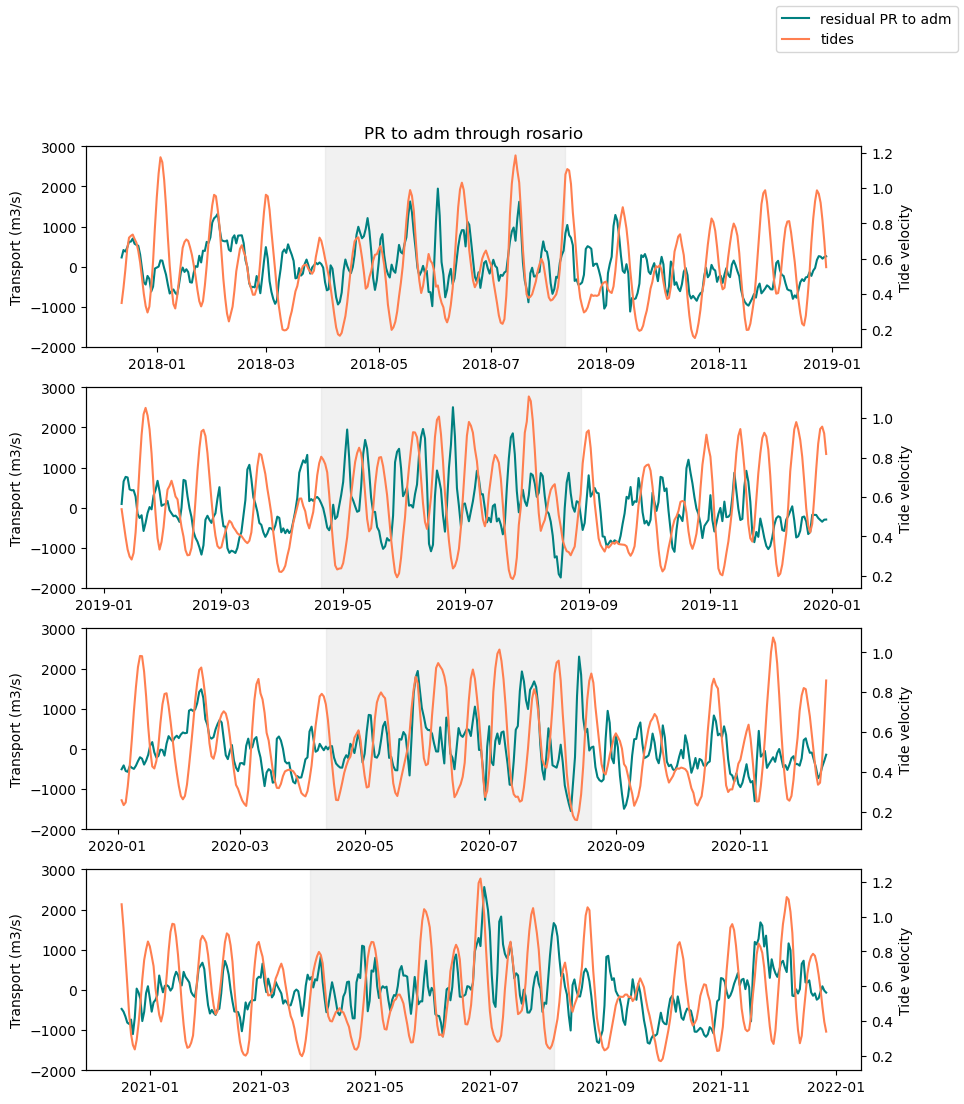

In [103]:
fig,[ax,ax4,ax5,ax6] = plt.subplots(4,1,figsize=(10,12))

ax.plot(res_prtoadm2018,color='teal',label='residual PR to adm')
ax2 = ax.twinx()
ax2.plot(date_prtoadm2018,tides_prtoadm2018,color='coral',label='tides')
ax.set_title(f'PR to adm through rosario')
ax.set_ylim([-2000,3000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2018[110],x2=date_prtoadm2018[240],color='lightgrey', alpha=0.3)
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
fig.legend()

ax4.plot(res_prtoadm2019,color='teal')
ax42 = ax4.twinx()
ax42.plot(date_prtoadm2019[0:379],tides_prtoadm2019[0:379],color='coral')
ax4.set_ylim([-2000,3000])
ax4.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2019[100],x2=date_prtoadm2019[230],color='lightgrey', alpha=0.3)
# ax43.spines['right'].set_position(('outward', 60))
ax4.set_ylabel('Transport (m3/s)')
ax42.set_ylabel('Tide velocity')

ax5.plot(res_prtoadm2020,color='teal')
ax52 = ax5.twinx()
ax52.plot(date_prtoadm2020,tides_prtoadm2020,color='coral')
ax5.set_ylim([-2000,3000])
ax5.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2020[100],x2=date_prtoadm2020[230],color='lightgrey', alpha=0.3)
ax5.set_ylabel('Transport (m3/s)')
ax52.set_ylabel('Tide velocity')

ax6.plot(res_prtoadm2021,color='teal')
ax62 = ax6.twinx()
ax62.plot(date_prtoadm2021,tides_prtoadm2021,color='coral')
ax6.set_ylim([-2000,3000])
ax6.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtoadm2021[100],x2=date_prtoadm2021[230],color='lightgrey', alpha=0.3)
ax6.set_ylabel('Transport (m3/s)')
ax62.set_ylabel('Tide velocity')

corr,p = stats.spearmanr(tides_prtoadm2018[100:230],res_prtoadm2018[100:230])
print(corr)
corr,p = stats.spearmanr(tides_prtoadm2019[100:230],res_prtoadm2019[100:230])
print(corr)
corr,p = stats.spearmanr(tides_prtoadm2020[100:230],res_prtoadm2020[100:230])
print(corr)
corr,p = stats.spearmanr(tides_prtoadm2021[100:230],res_prtoadm2021[100:230])
print(corr)

-0.1669365961572601
-0.43200644553387313
-0.28859877917218585
-0.2990864275082276


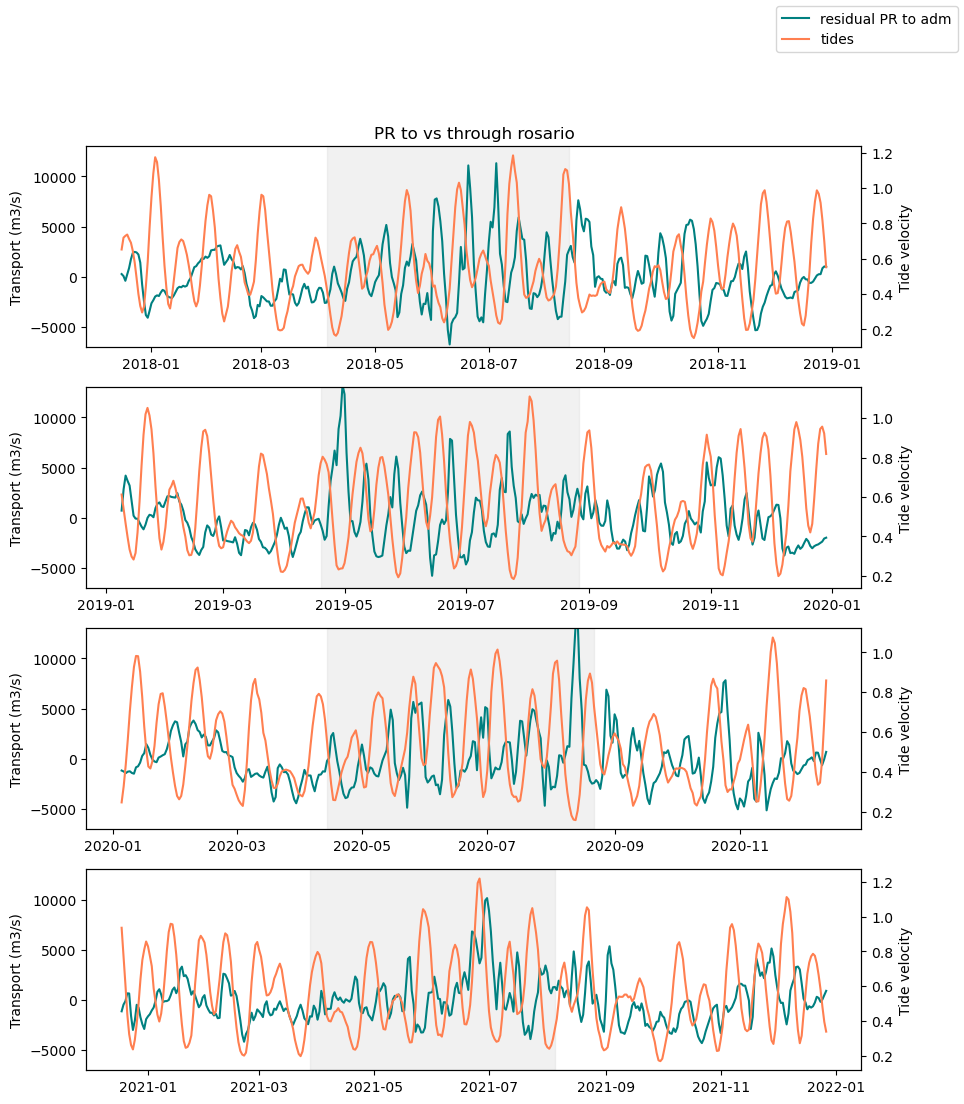

In [108]:
fig,[ax,ax4,ax5,ax6] = plt.subplots(4,1,figsize=(10,12))

ax.plot(res_prtovs2018,color='teal',label='residual PR to adm')
ax2 = ax.twinx()
ax2.plot(date_prtovs2018,tides_prtovs2018,color='coral',label='tides')
ax.set_title(f'PR to vs through rosario')
ax.set_ylim([-7000,13000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtovs2018[110],x2=date_prtovs2018[240],color='lightgrey', alpha=0.3)
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
fig.legend()

ax4.plot(res_prtovs2019,color='teal')
ax42 = ax4.twinx()
ax42.plot(date_prtovs2019[0:379],tides_prtovs2019[0:379],color='coral')
ax4.set_ylim([-7000,13000])
ax4.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtovs2019[100],x2=date_prtovs2019[230],color='lightgrey', alpha=0.3)
# ax43.spines['right'].set_position(('outward', 60))
ax4.set_ylabel('Transport (m3/s)')
ax42.set_ylabel('Tide velocity')

ax5.plot(res_prtovs2020,color='teal')
ax52 = ax5.twinx()
ax52.plot(date_prtovs2020,tides_prtovs2020,color='coral')
ax5.set_ylim([-7000,13000])
ax5.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtovs2020[100],x2=date_prtovs2020[230],color='lightgrey', alpha=0.3)
ax5.set_ylabel('Transport (m3/s)')
ax52.set_ylabel('Tide velocity')

ax6.plot(res_prtovs2021,color='teal')
ax62 = ax6.twinx()
ax62.plot(date_prtovs2021,tides_prtovs2021,color='coral')
ax6.set_ylim([-7000,13000])
ax6.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_prtovs2021[100],x2=date_prtovs2021[230],color='lightgrey', alpha=0.3)
ax6.set_ylabel('Transport (m3/s)')
ax62.set_ylabel('Tide velocity')

corr,p = stats.spearmanr(tides_prtovs2018[100:230],res_prtovs2018[100:230])
print(corr)
corr,p = stats.spearmanr(tides_prtovs2019[100:230],res_prtovs2019[100:230])
print(corr)
corr,p = stats.spearmanr(tides_prtovs2020[100:230],res_prtovs2020[100:230])
print(corr)
corr,p = stats.spearmanr(tides_prtovs2021[100:230],res_prtovs2021[100:230])
print(corr)

0.3084970561848773
0.45139522978365704
0.4029735251026598
0.4634656957560587


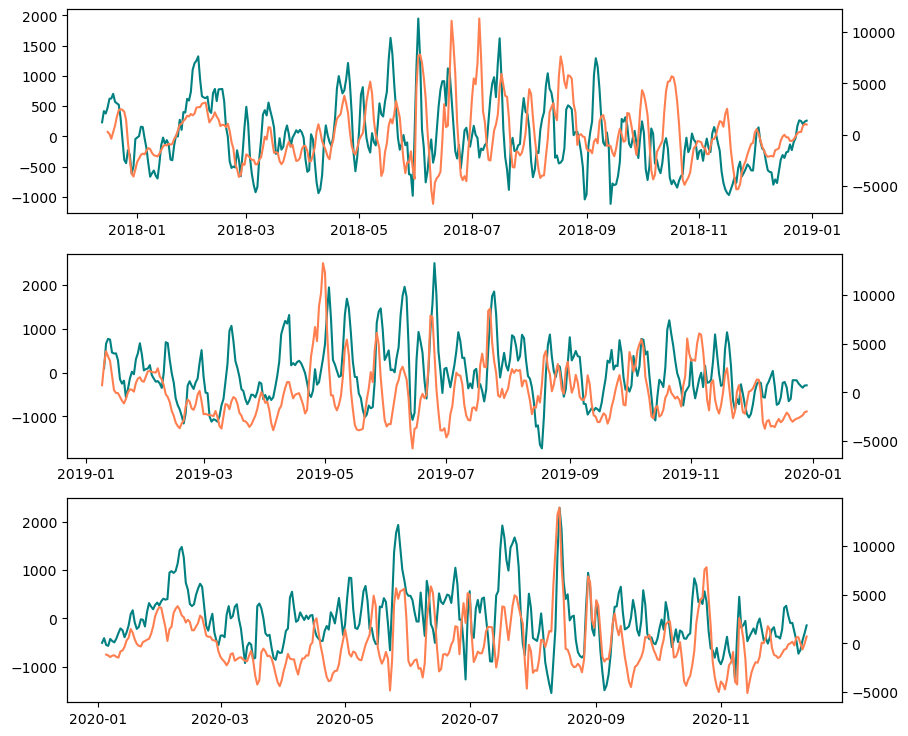

In [176]:
fig,[ax,ax3,ax4] = plt.subplots(3,1,figsize=(10,9))
ax.plot(res_prtoadm2018,color='teal')
ax2 = ax.twinx()
ax2.plot(res_prtovs2018,color='coral')
ax3.plot(res_prtoadm2019,color='teal')
ax32 = ax3.twinx()
ax32.plot(res_prtovs2019,color='coral')
ax4.plot(res_prtoadm2020,color='teal')
ax42 = ax4.twinx()
ax42.plot(res_prtovs2020,color='coral')
ax5.plot(res_prtoadm2021,color='teal')
ax52 = ax5.twinx()
ax52.plot(res_prtovs2021,color='coral')

corr,p = stats.spearmanr(res_prtoadm2018[3:],res_prtovs2018)
print(corr)
corr,p = stats.spearmanr(res_prtoadm2019,res_prtovs2019[1:])
print(corr)
corr,p = stats.spearmanr(res_prtoadm2020[2:],res_prtovs2020)
print(corr)
corr,p = stats.spearmanr(res_prtoadm2021[1:],res_prtovs2021)
print(corr)

In [169]:
res_prtoadm2019,res_prtovs2019

(2019-01-10     96.656532
 2019-01-11    659.675162
 2019-01-12    771.377943
 2019-01-13    755.688394
 2019-01-14    460.104523
                  ...    
 2019-12-25   -252.834528
 2019-12-26   -301.432536
 2019-12-27   -345.418754
 2019-12-28   -294.950041
 2019-12-29   -291.136044
 Name: Transport, Length: 354, dtype: float64,
 2019-01-09     724.075097
 2019-01-10    2856.886150
 2019-01-11    4211.039366
 2019-01-12    3682.923327
 2019-01-13    3219.291297
                  ...     
 2019-12-25   -2638.837670
 2019-12-26   -2501.718963
 2019-12-27   -2364.662675
 2019-12-28   -2056.310335
 2019-12-29   -1972.132847
 Name: Transport, Length: 355, dtype: float64)

In [156]:
corr,p = stats.spearmanr(res_prtoadm2018[103:233],tides_prtovs2018[100:230])
print(corr)
corr,p = stats.spearmanr(res_prtoadm2018[103:233],tides_prtoadm2018[103:233])
print(corr)

0.5493697851943902
0.5493697851943902


In [155]:
print(res_prtoadm2018[103])
print(tides_prtoadm2018[103:104])
print(res_prtoadm2018[103])
print(tides_prtovs2018[100:101])

-19.477581893256
449    0.514829
Name: vozocrtx, dtype: float64
-19.477581893256
449    0.514829
Name: vozocrtx, dtype: float64


In [161]:
PRtoadm2021_ros_avg.dropna()

2020-12-17    990.930525
2020-12-18    920.781478
2020-12-19    744.999923
2020-12-20    574.233570
2020-12-21    497.342867
                 ...    
2021-12-23    544.166045
2021-12-24    821.834805
2021-12-25    938.448244
2021-12-26    795.060246
2021-12-27    667.518458
Name: Transport, Length: 376, dtype: float64